In [130]:
# Notebook: Optimisation de la prédiction des prix des maisons - Kaggle
from google.colab import drive
drive.mount('/content/drive')

# Étape 1 : Importations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew
from scipy.special import boxcox1p




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
# Chargement des données
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [132]:
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [133]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df.head()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [134]:
test_df.describe()

Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000  1232.000000   1459.000000  1459.000000   
mean   2190.000000    57.378341    68.580357   9819.161069     6.078821   
std     421.321334    42.746880    22.376841   4955.517327     1.436812   
min    1461.000000    20.000000    21.000000   1470.000000     1.000000   
25%    1825.500000    20.000000    58.000000   7391.000000     5.000000   
50%    2190.000000    50.000000    67.000000   9399.000000     6.000000   
75%    2554.500000    70.000000    80.000000  11517.500000     7.000000   
max    2919.000000   190.000000   200.000000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1459.000000  1459.000000   1459.000000  1444.000000  1458.000000  ...   
mean      5.553804  1971.357779   1983.662783   100.709141   439.203704  ...   
std       1.113740    30.390071     21.130467   177.625900   455.268042  ...   
min       1.000000  1879.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.000000   1963.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1992.000000     0.000000   350.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   753.500000  ...   
max       9.000000  2010.000000   2010.000000  1290.000000  4010.000000  ...   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1458.000000  1459.000000  1459.000000    1459.000000  1459.000000   
mean    472.768861    93.174777    48.313914      24.243317     1.794380   
std     217.048611   127.744882    68.883364      67.227765    20.207842   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     318.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    28.000000       0.000000     0.000000   
75%     576.000000   168.000000    72.000000       0.000000     0.000000   
max    1488.000000  1424.000000   742.000000    1012.000000   360.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000  
mean     17.064428     1.744345     58.167923     6.104181  2007.769705  
std      56.609763    30.491646    630.806978     2.722432     1.301740  
min       0.000000     0.000000      0.000000     1.000000  2006.000000  
25%       0.000000     0.000000      0.000000     4.000000  2007.000000  
50%       0.000000     0.000000      0.000000     6.000000  2008.000000  
75%       0.000000     0.000000      0.000000     8.000000  2009.000000  
max     576.000000   800.000000  17000.000000    12.000000  2010.000000  

[8 rows x 37 columns]

In [135]:
# Sauvegarde de l'ID pour la soumission
test_ID = test_df['Id']

#Visualisation des corrélations

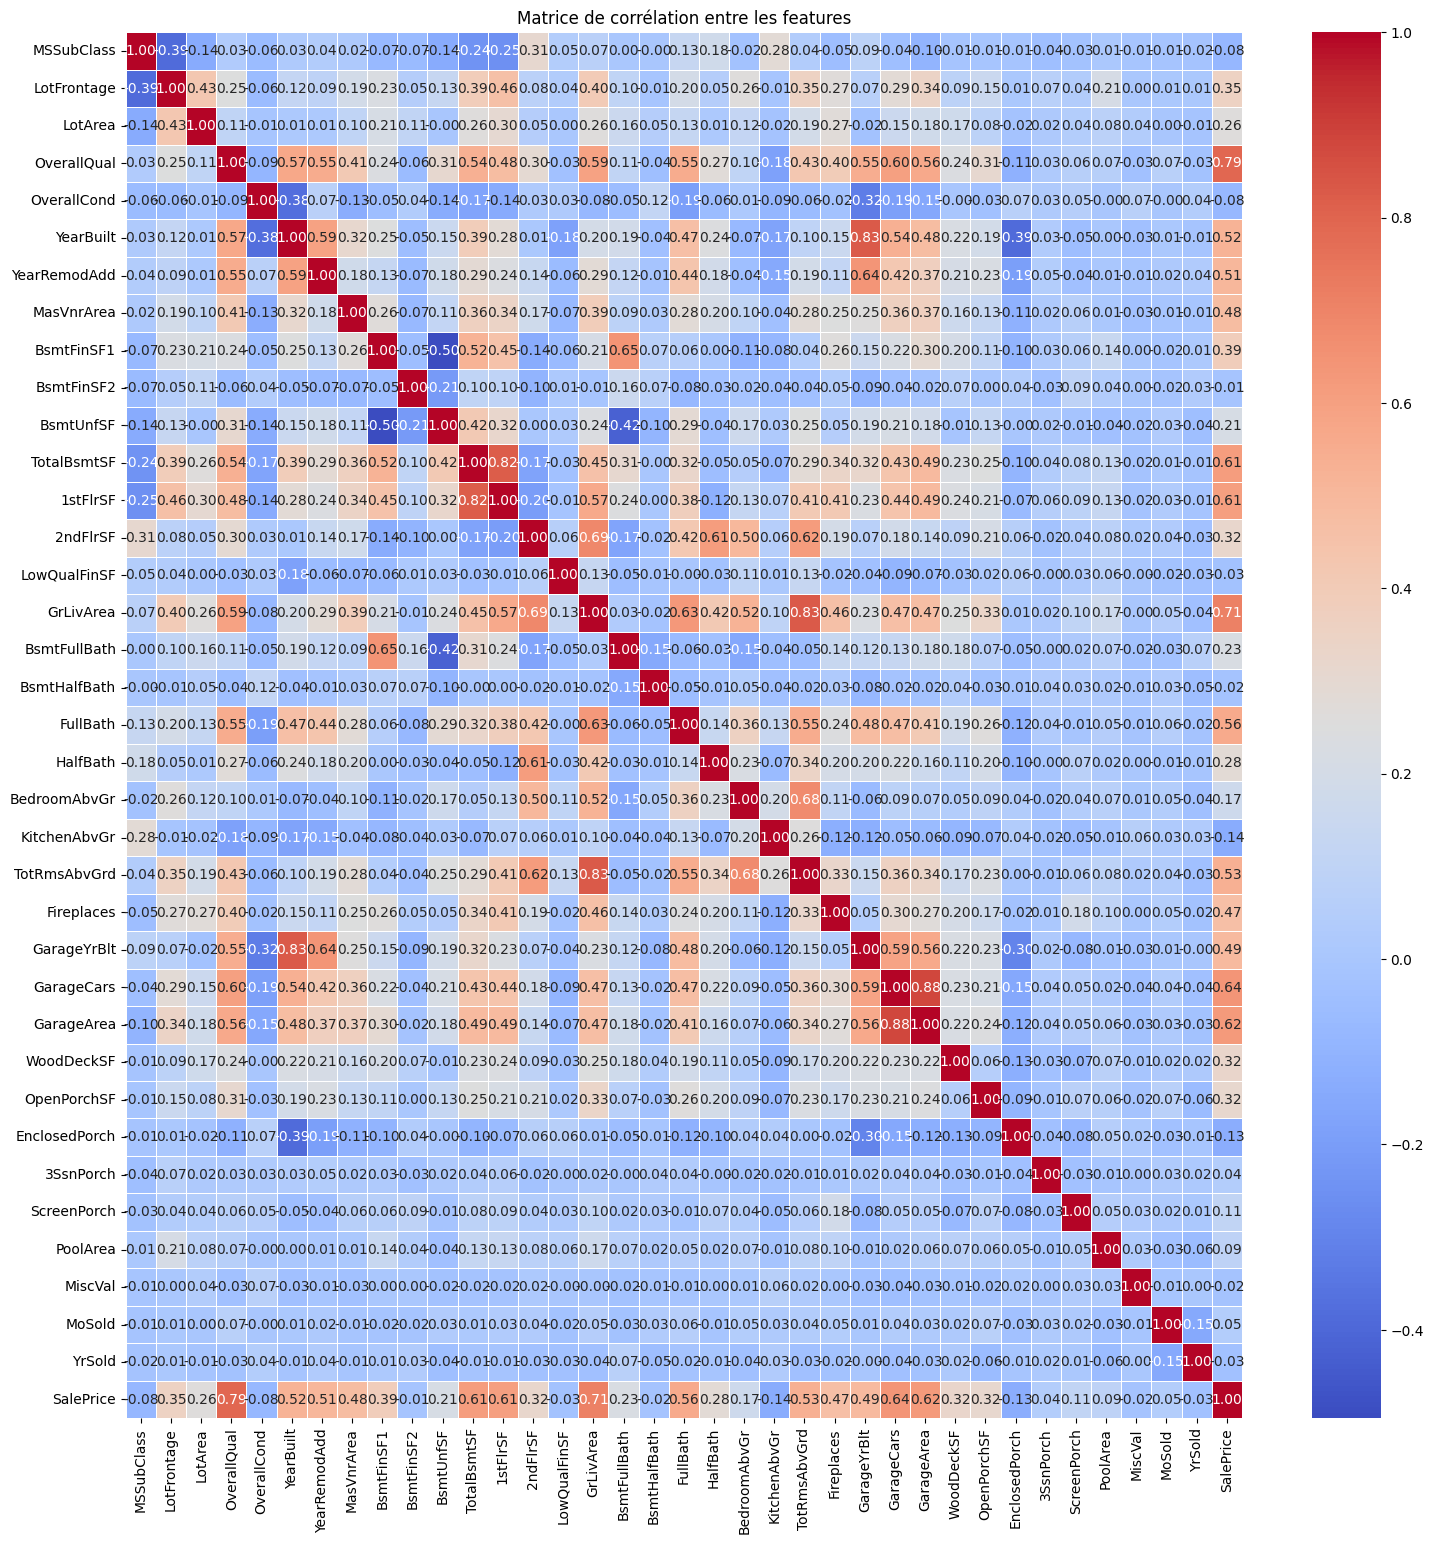

(1460, 37)

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner les colonnes numériques
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).drop(columns=["Id"])

# Calculer la matrice de corrélation
corr_matrix = numeric_features.corr()

# Créer la heatmap et l'afficher
plt.figure(figsize=(18, 18))  # Ajuste la taille de la figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de corrélation entre les features")
plt.show()
numeric_features.shape

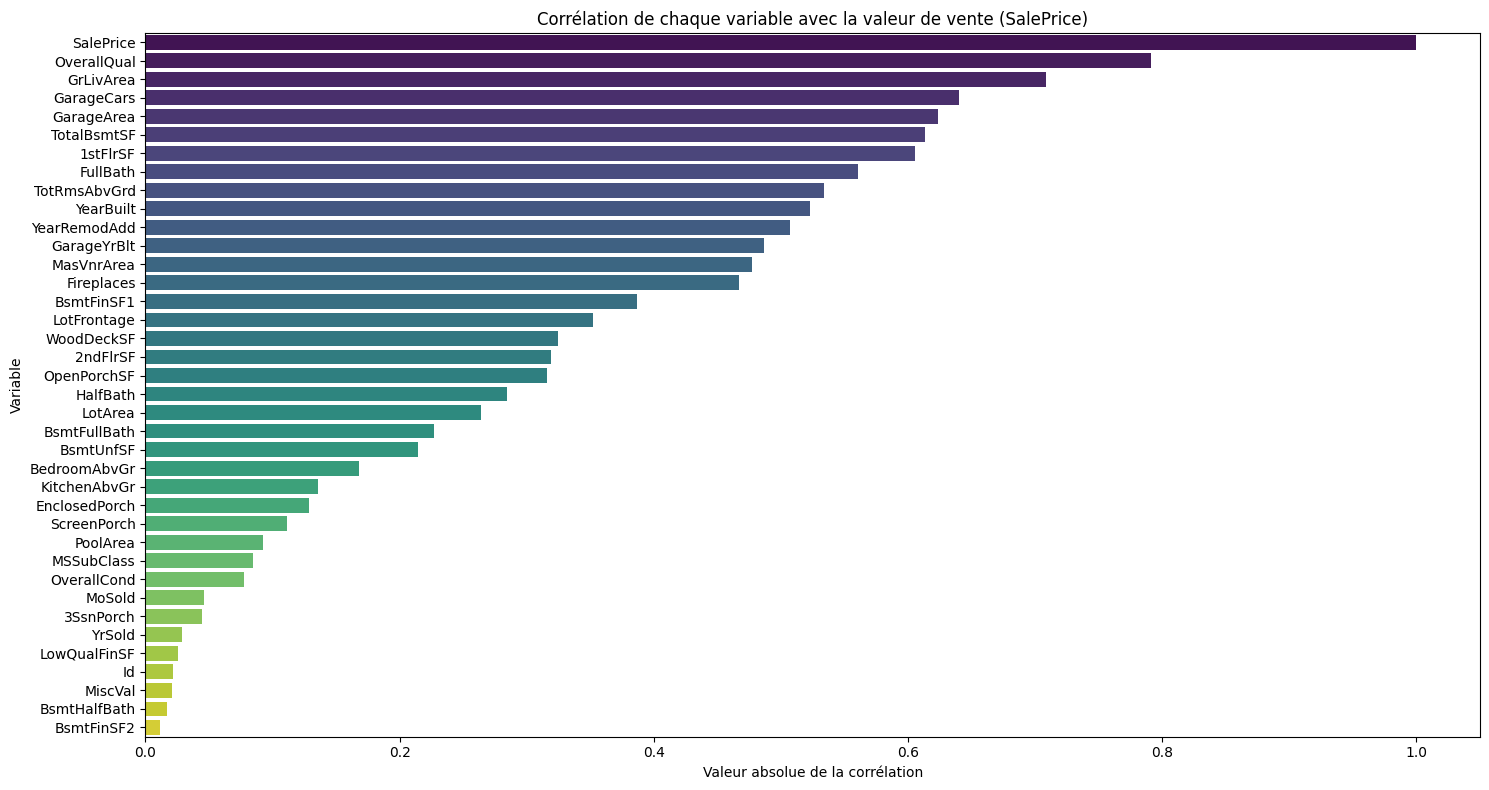

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner uniquement les colonnes numériques
numeric_train = train_df.select_dtypes(include=['number'])

# Calcul de la corrélation avec la cible "SalePrice"
correlations = abs(numeric_train.corr()["SalePrice"]).sort_values(ascending=False)

# Représentation graphique
plt.figure(figsize=(15, 8))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.xlabel("Valeur absolue de la corrélation")
plt.ylabel("Variable")
plt.title("Corrélation de chaque variable avec la valeur de vente (SalePrice)")
plt.tight_layout()
plt.show()


In [138]:
from scipy.stats import kruskal
from scipy.stats import f_oneway

def check_significant_category_values(df):
    # Identifier les variables catégorielles
    categorical_features = df.select_dtypes(include=['object']).columns

    # Parcourir et tester chaque variable
    print("Résultat du test ANOVA pour les variables catégorielles par rapport à SalePrice :\n")

    for cat in categorical_features:
        try:
            groups = [df['SalePrice'][df[cat] == level] for level in df[cat].unique()]
            groups = [g for g in groups if len(g) > 1]  # éviter les groupes trop petits

            if len(groups) > 1:
                f_stat, p_val = f_oneway(*groups)
                result = "✅ Significative" if p_val < 0.05 else "❌ Non significative"
                print(f"{cat:<20} | p-value: {p_val:.5f} | {result}")
        except Exception as e:
            print(f"{cat:<20} | Erreur lors du test: {e}")



    print("\n--- Test de Kruskal-Wallis (non paramétrique) ---\n")

    categorical_features = df.select_dtypes(include=['object']).columns
    for cat in categorical_features:
        try:
            groups = [df['SalePrice'][df[cat] == level] for level in df[cat].unique()]
            groups = [g for g in groups if len(g) > 1]

            if len(groups) > 1:
                h_stat, p_val = kruskal(*groups)
                result = "✅ Significative" if p_val < 0.05 else "❌ Non significative"
                print(f"{cat:<20} | p-value: {p_val:.5f} | {result}")
        except Exception as e:
            print(f"{cat:<20} | Erreur lors du test Kruskal: {e}")

    from scipy.stats import chi2_contingency

    print("\n--- Test du Chi² entre variables catégorielles (ex: MSZoning vs Neighborhood) ---\n")


    categorical_features = df.select_dtypes(include=['object']).columns

    for cat in categorical_features:
        if cat != 'SalePrice':
            try:
                contingency_table = pd.crosstab(df[cat], df['Neighborhood'])
                chi2, p_val, dof, expected = chi2_contingency(contingency_table)
                result = "✅ Significative" if p_val < 0.05 else "❌ Non significative"
                print(f"{cat:<20} | p-value: {p_val:.5f} | {result}")
            except Exception as e:
                print(f"{cat:<20} | Erreur Chi²: {e}")

check_significant_category_values(train_df)




Résultat du test ANOVA pour les variables catégorielles par rapport à SalePrice :

MSZoning             | p-value: 0.00000 | ✅ Significative
Street               | p-value: 0.11705 | ❌ Non significative
Alley                | p-value: 0.00000 | ✅ Significative
LotShape             | p-value: 0.00000 | ✅ Significative
LandContour          | p-value: 0.00000 | ✅ Significative
LotConfig            | p-value: 0.00000 | ✅ Significative
LandSlope            | p-value: 0.14140 | ❌ Non significative
Neighborhood         | p-value: 0.00000 | ✅ Significative
Condition1           | p-value: 0.00000 | ✅ Significative
Condition2           | p-value: 0.02824 | ✅ Significative
BldgType             | p-value: 0.00000 | ✅ Significative
HouseStyle           | p-value: 0.00000 | ✅ Significative
RoofStyle            | p-value: 0.00000 | ✅ Significative
RoofMatl             | p-value: 0.00000 | ✅ Significative
Exterior1st          | p-value: 0.00000 | ✅ Significative
Exterior2nd          | p-value: 0.00000

#Traitement des outliers

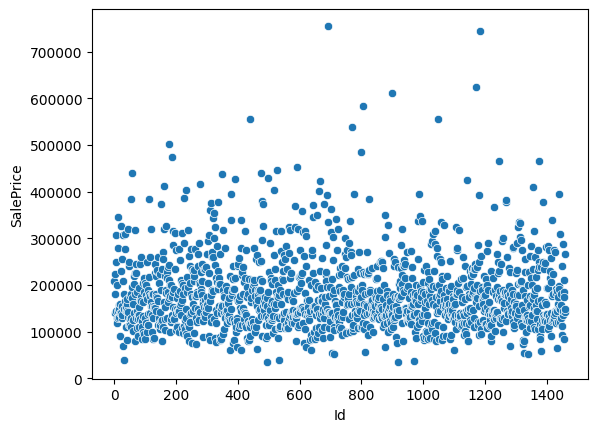

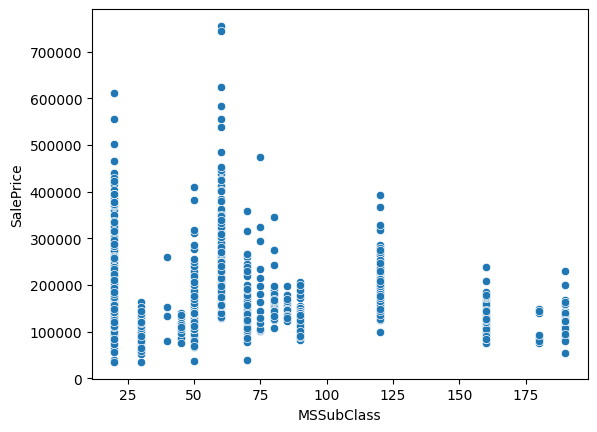

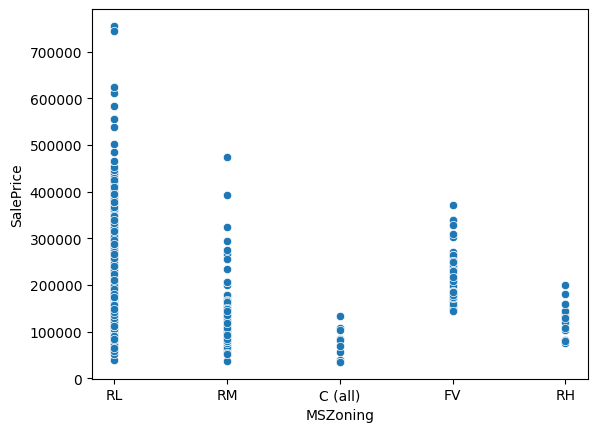

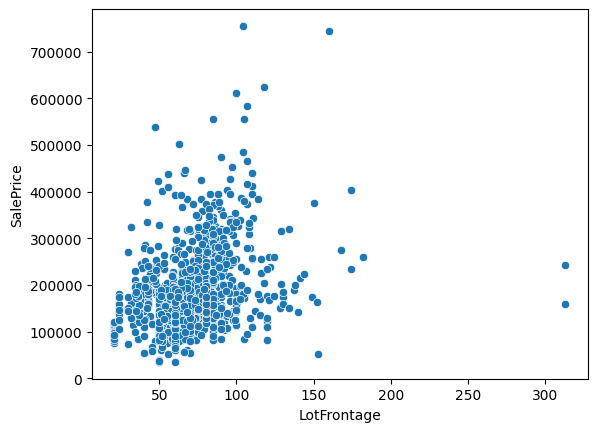

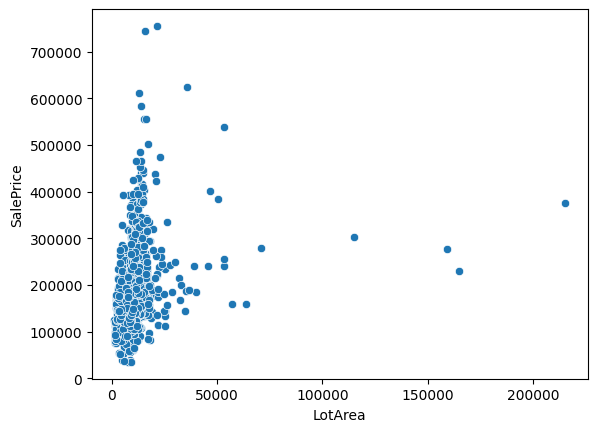

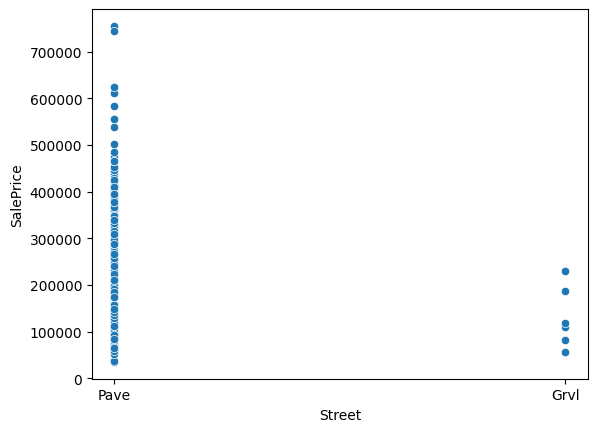

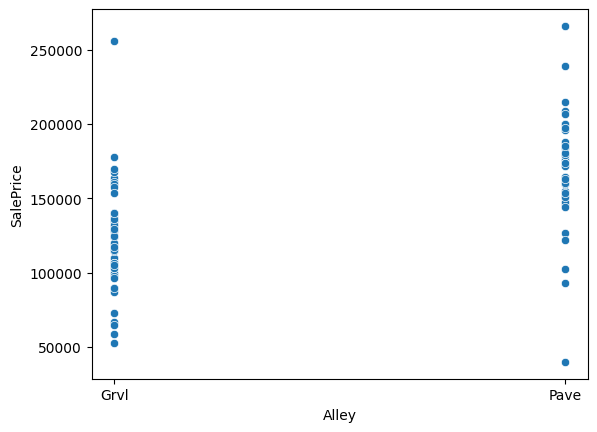

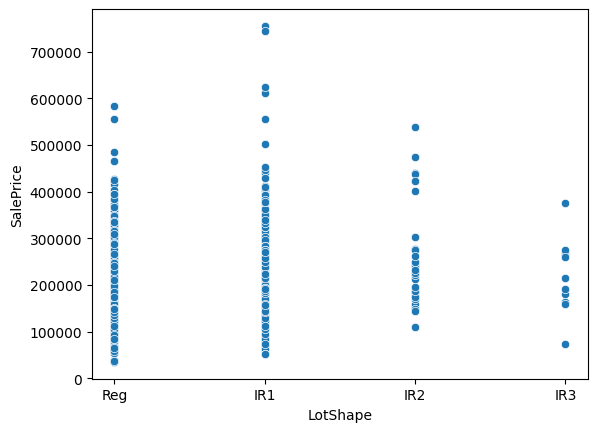

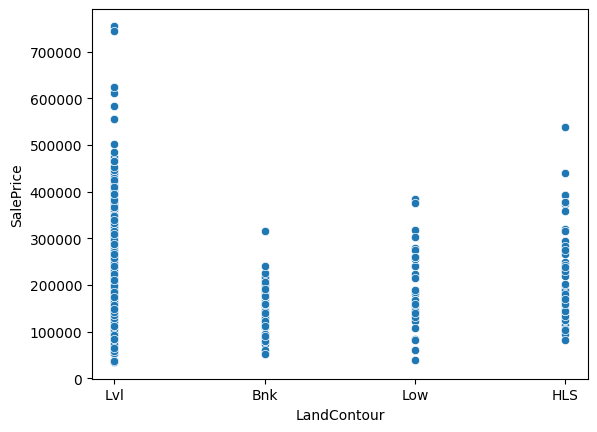

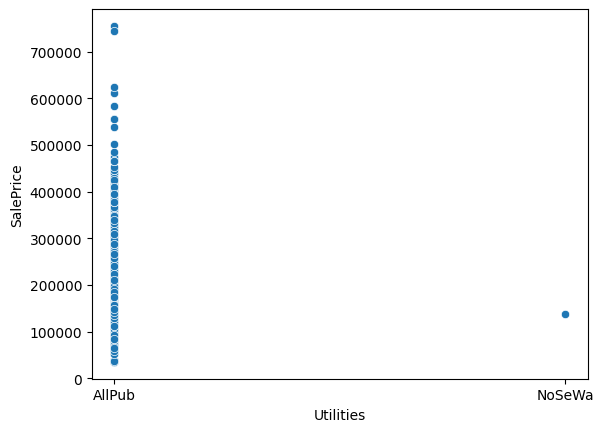

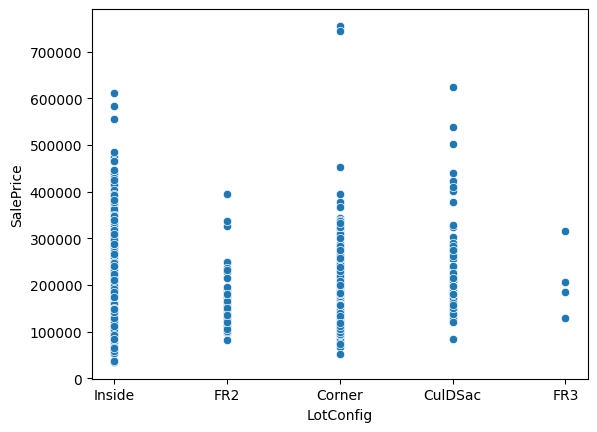

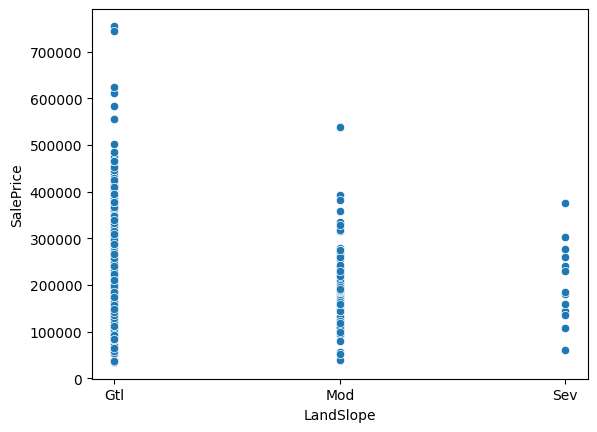

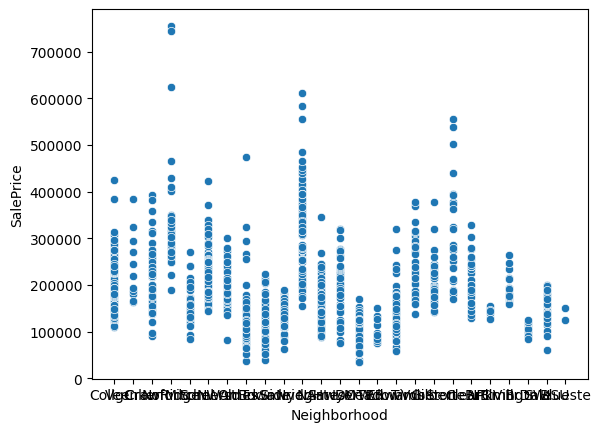

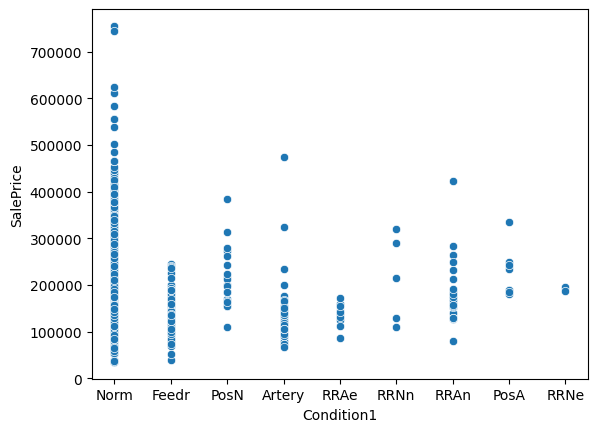

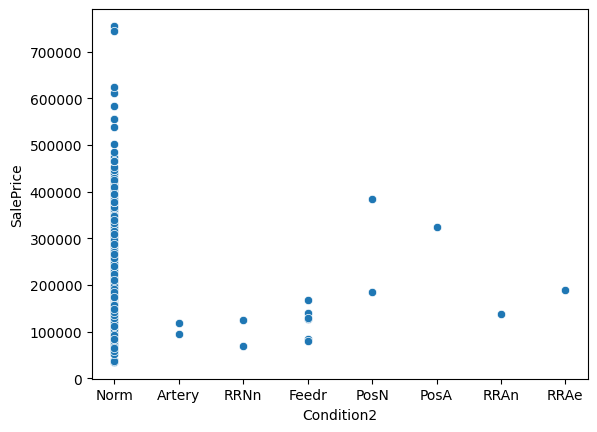

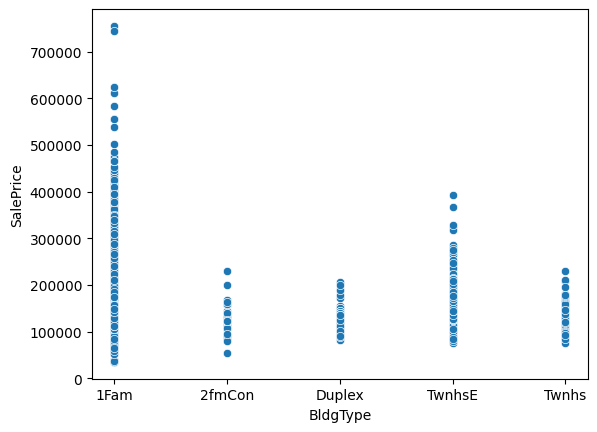

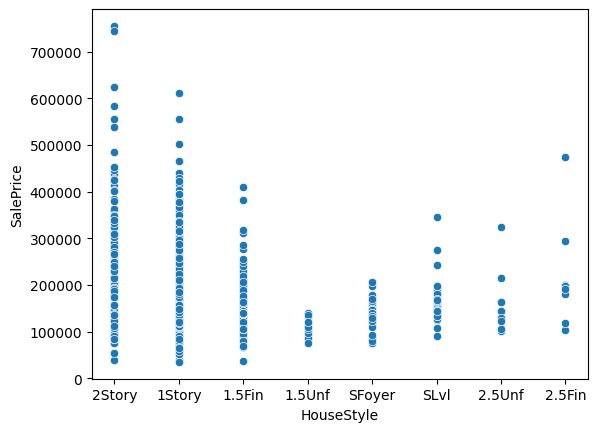

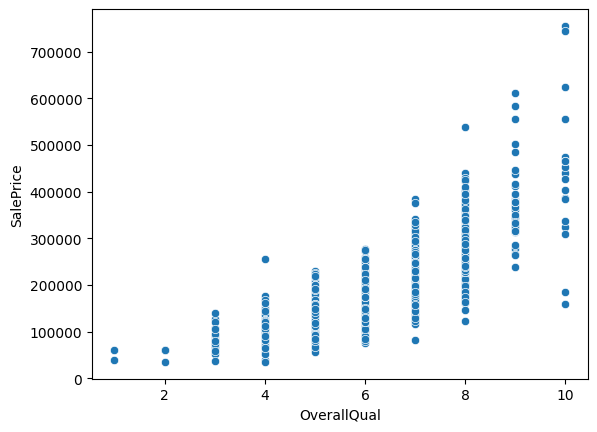

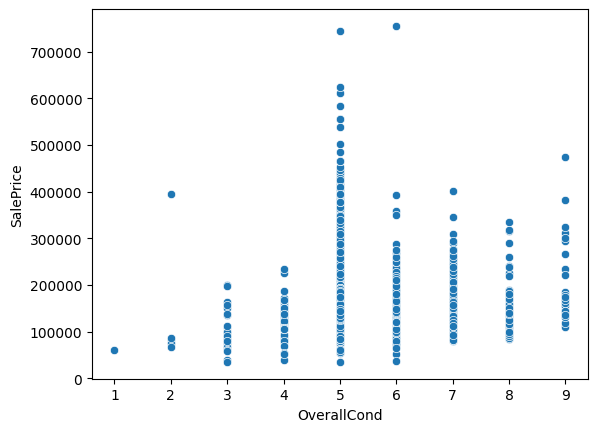

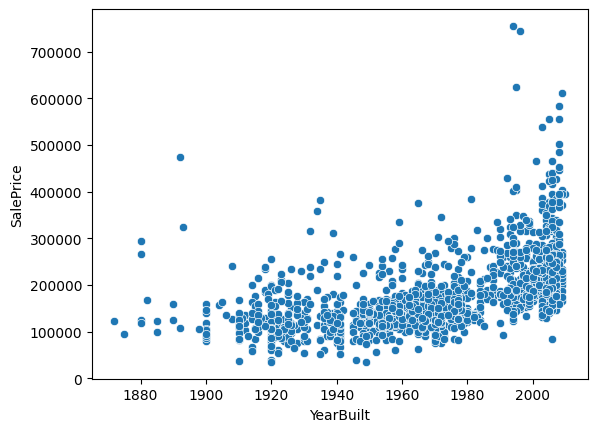

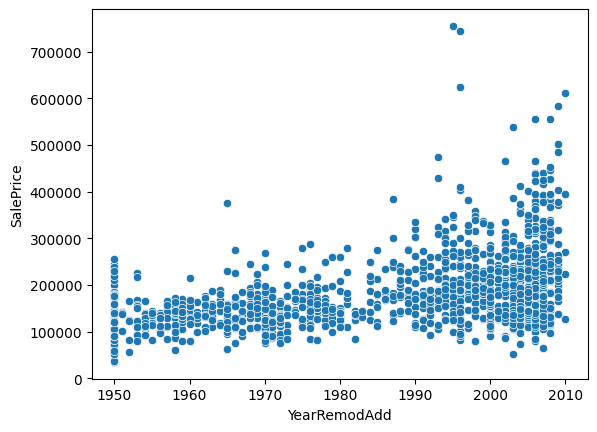

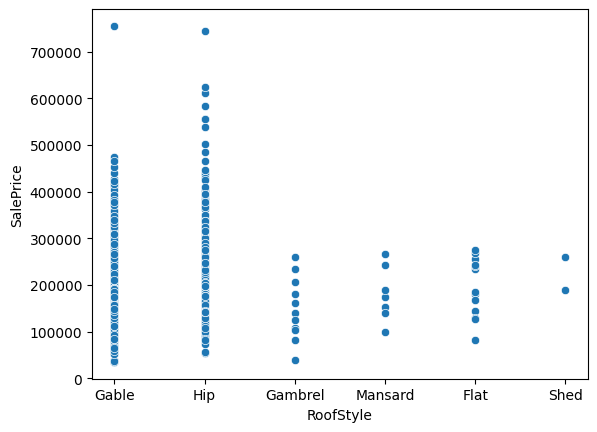

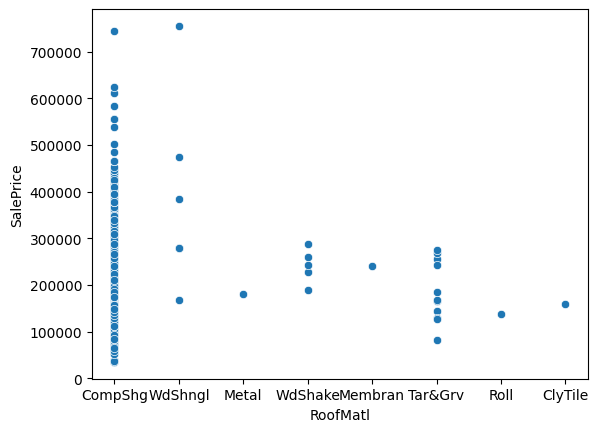

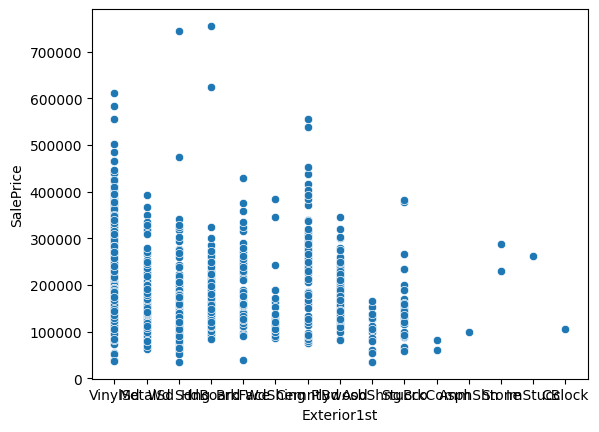

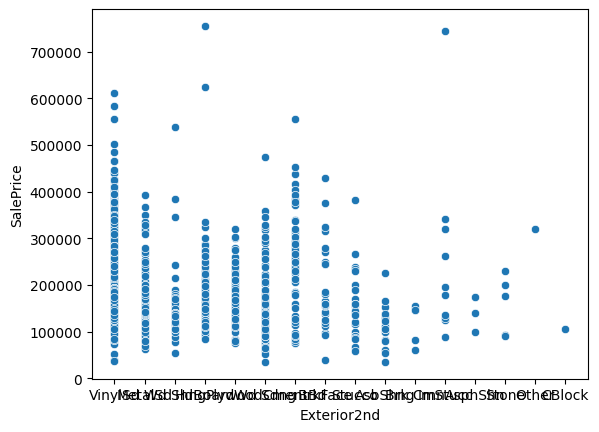

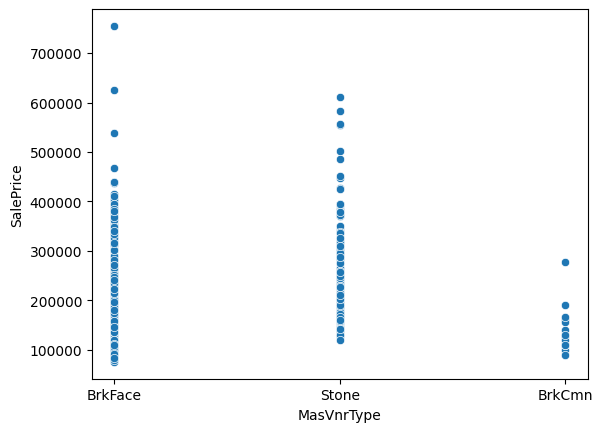

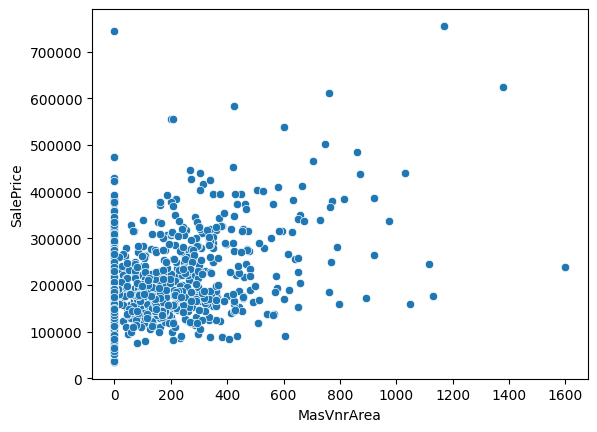

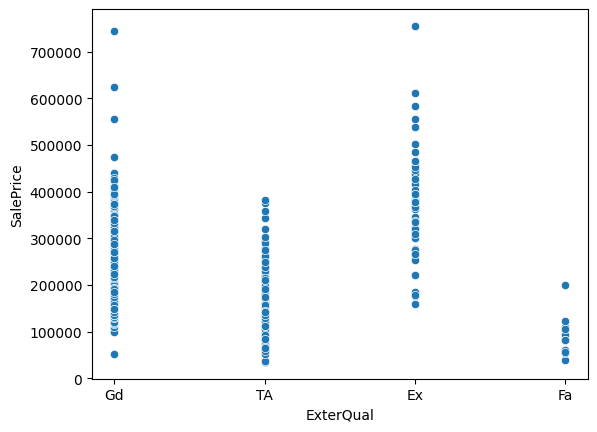

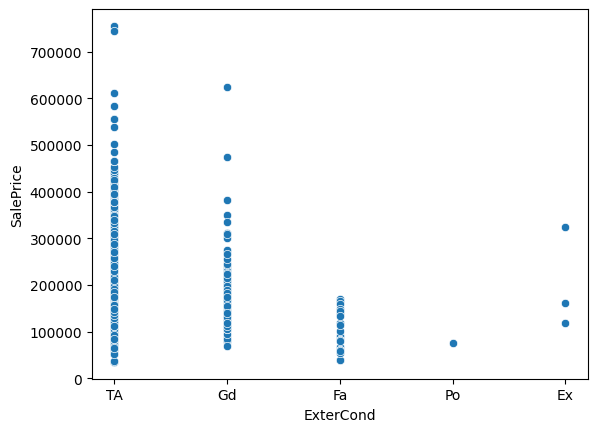

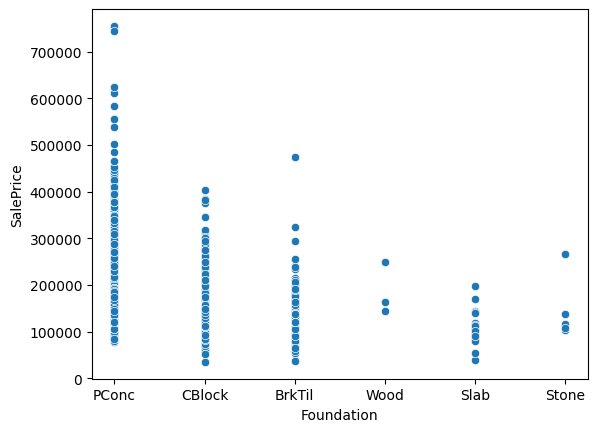

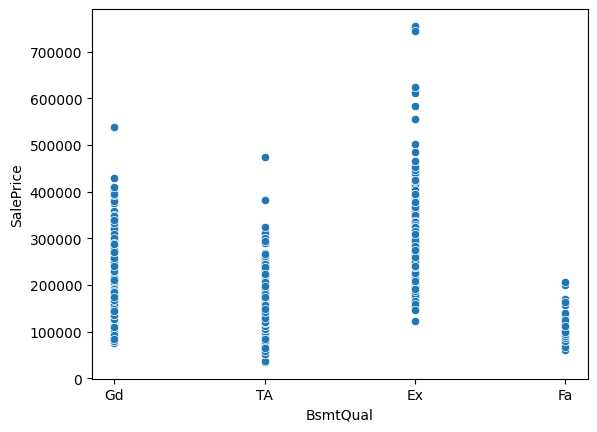

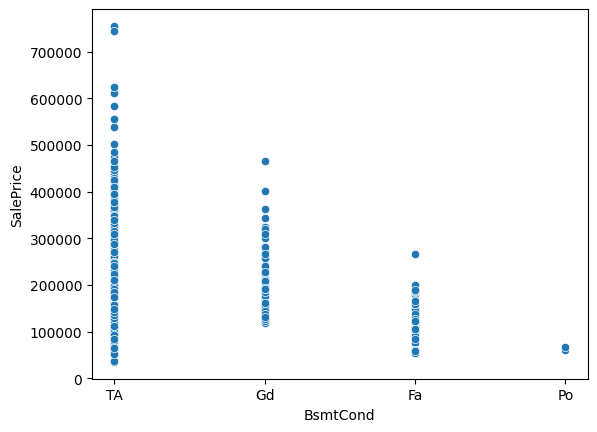

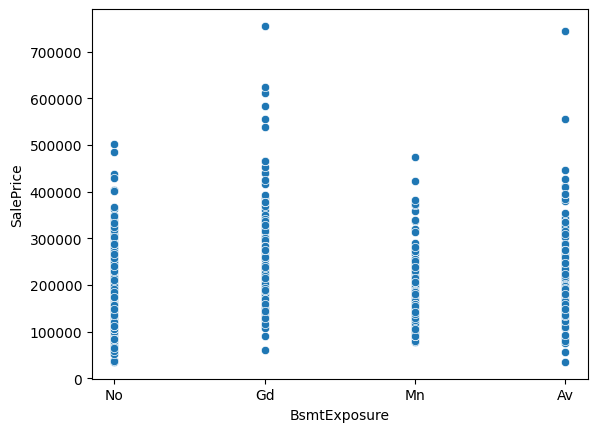

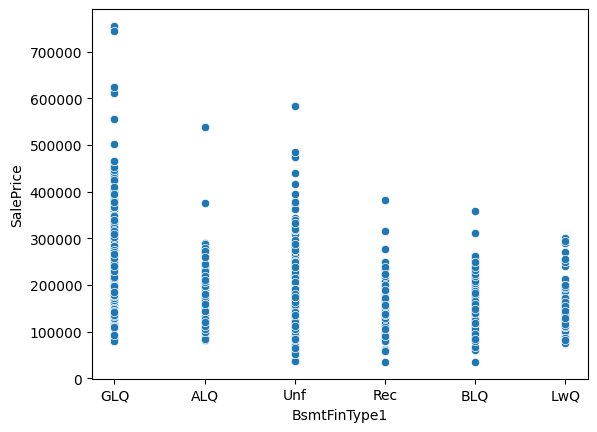

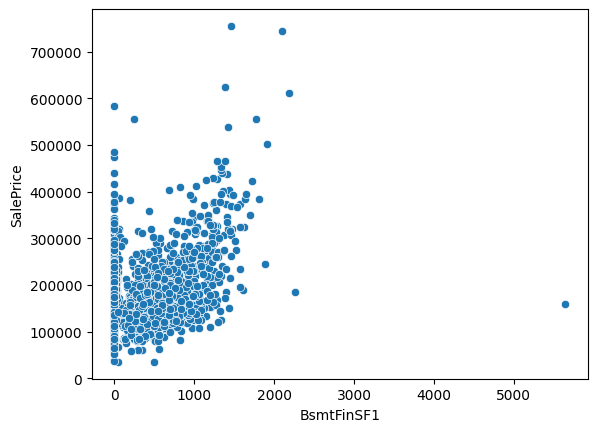

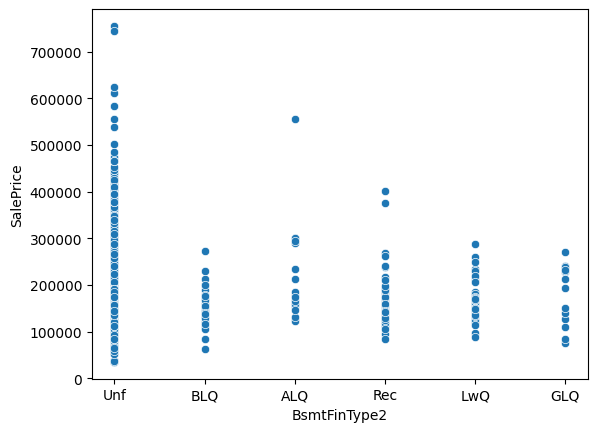

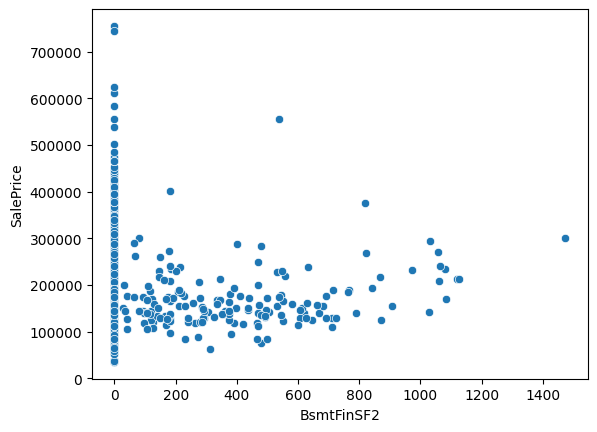

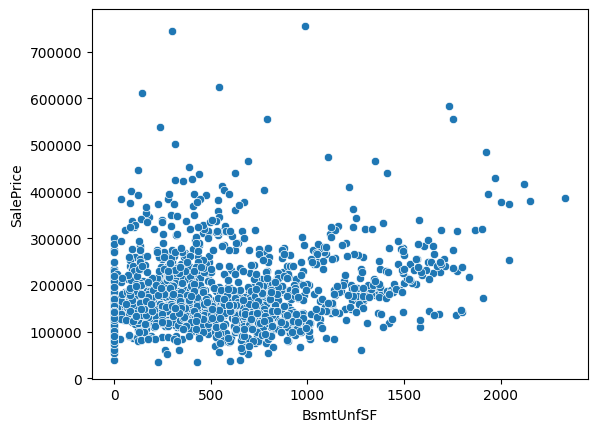

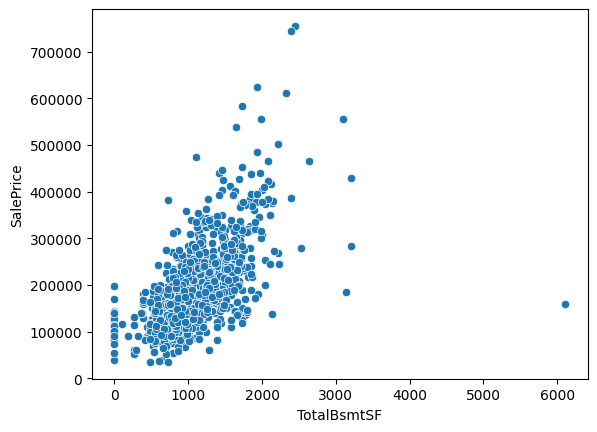

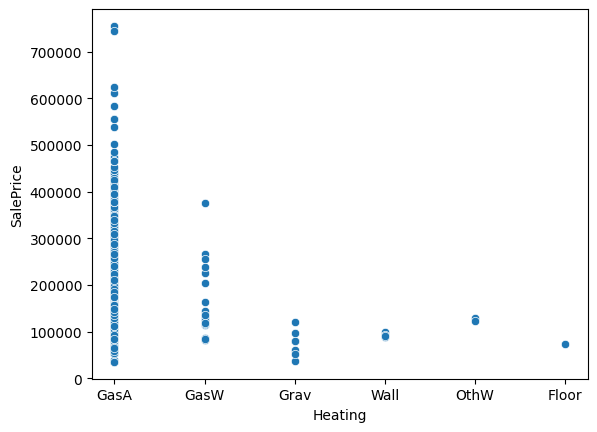

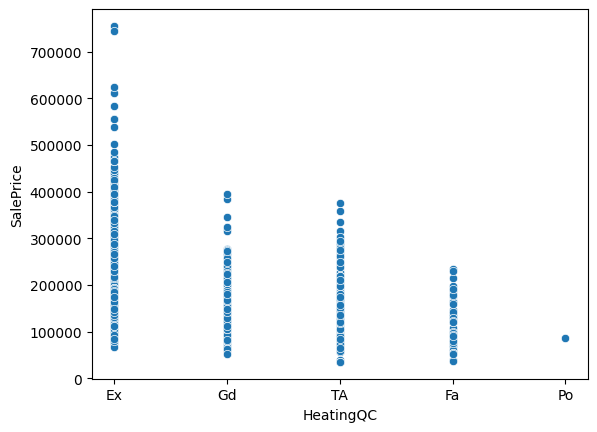

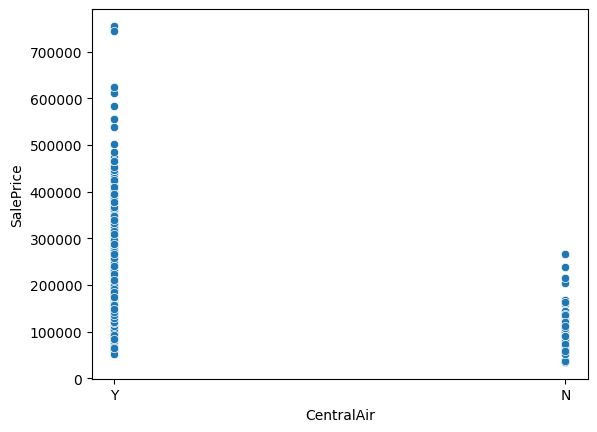

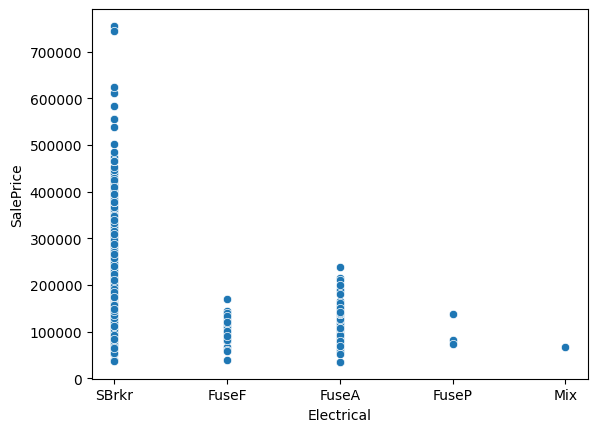

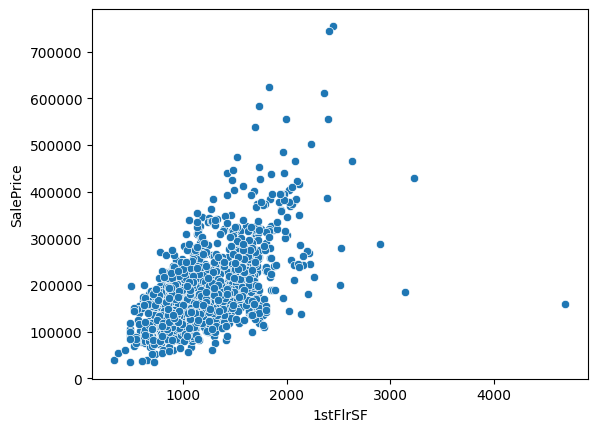

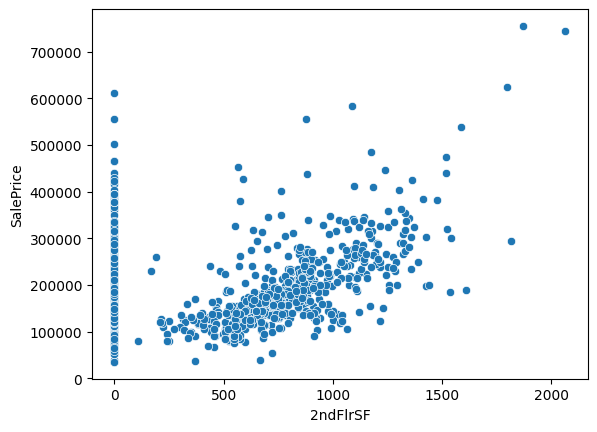

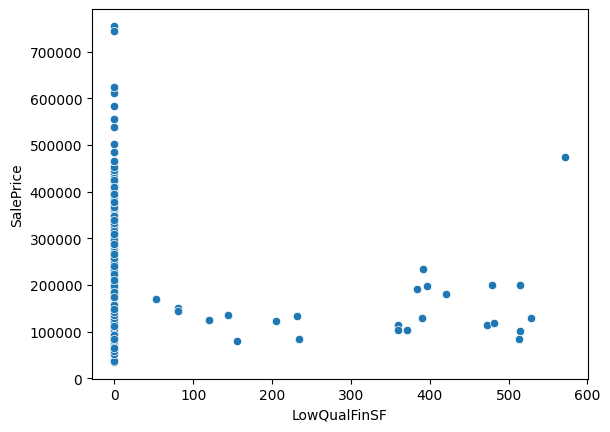

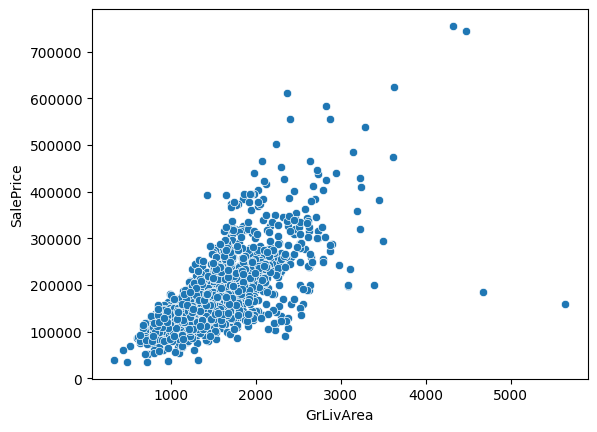

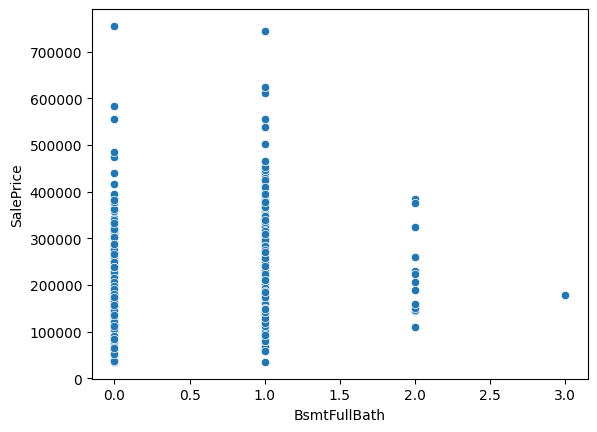

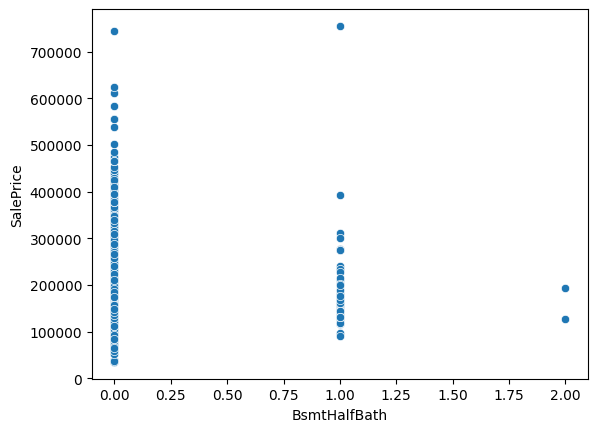

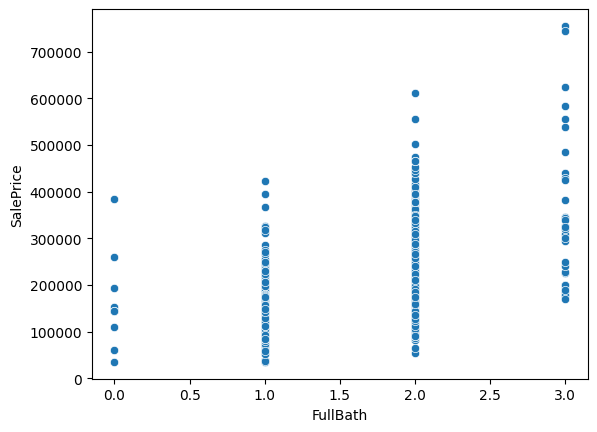

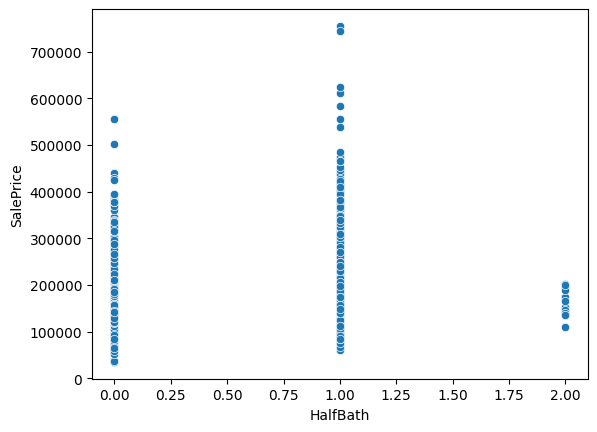

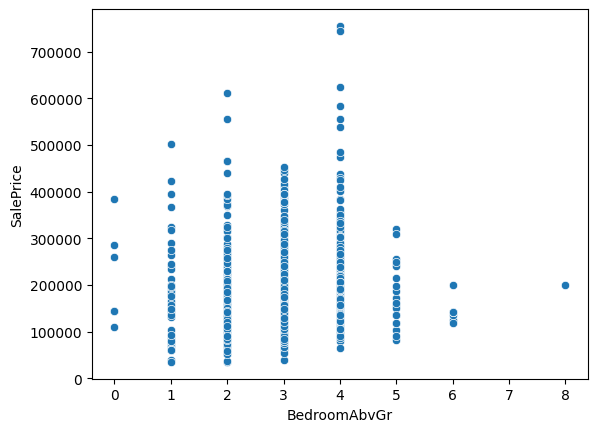

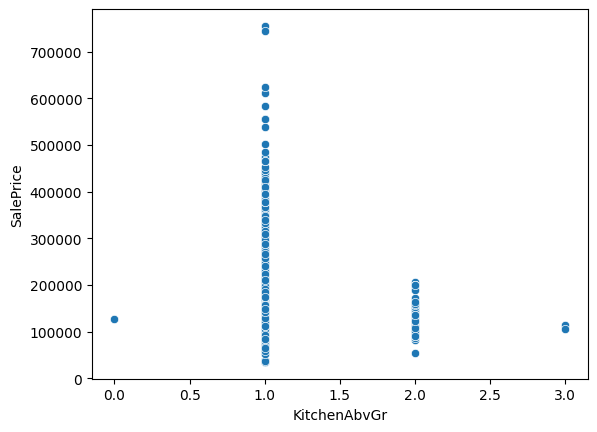

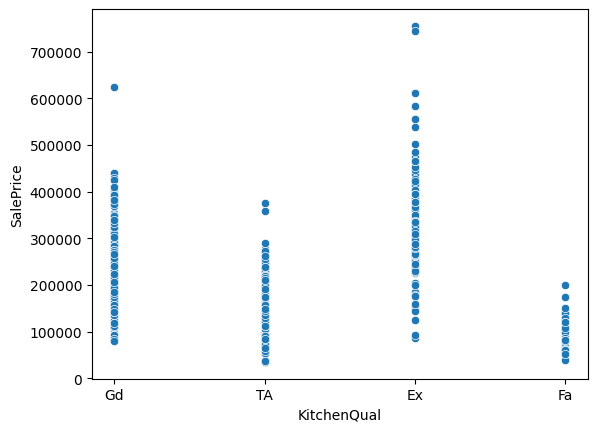

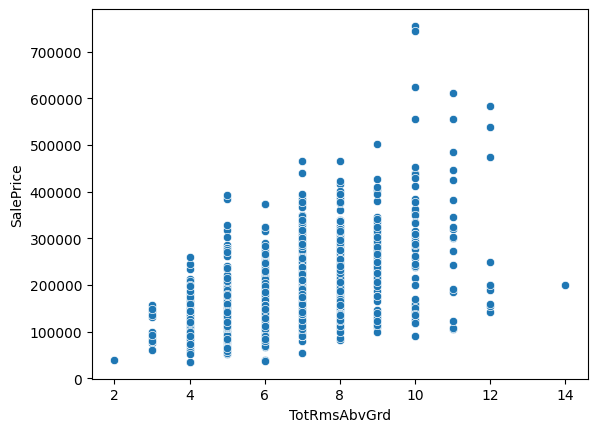

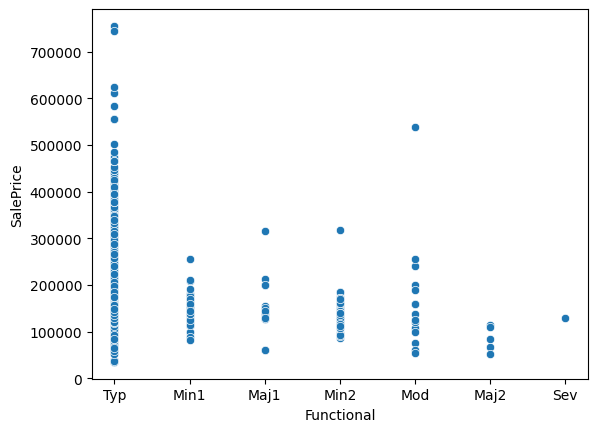

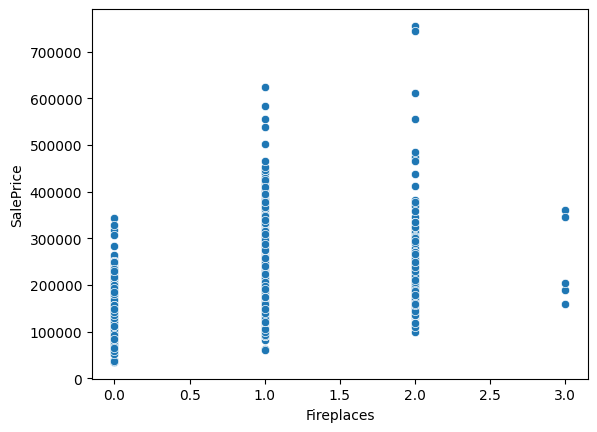

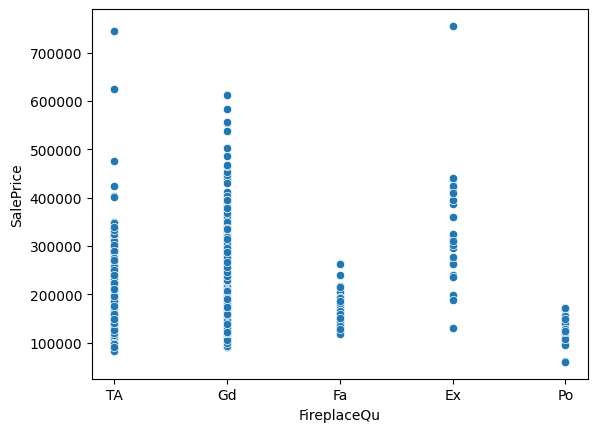

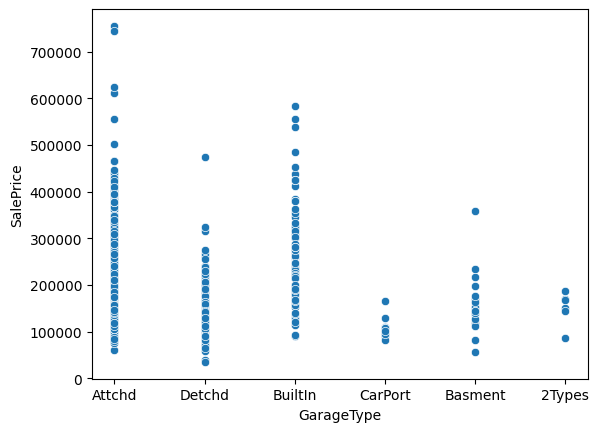

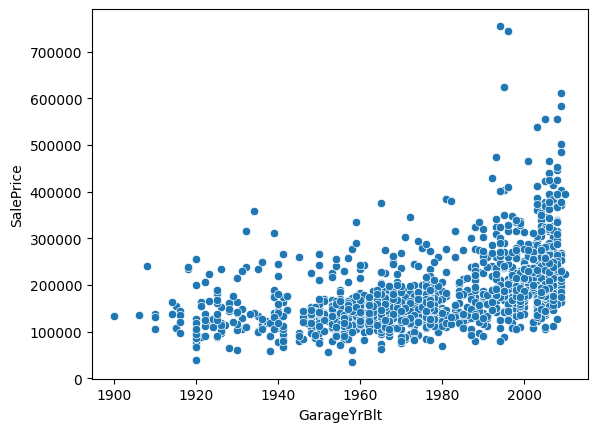

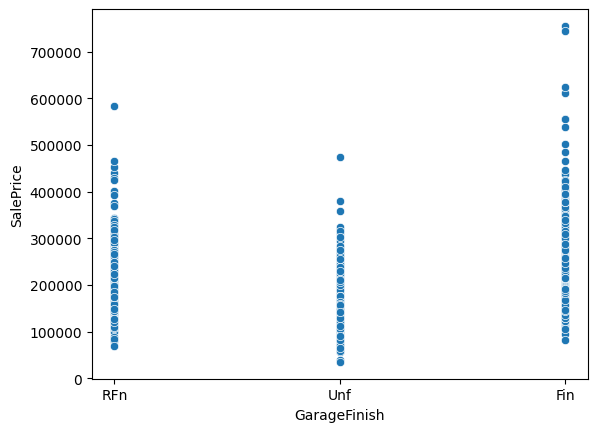

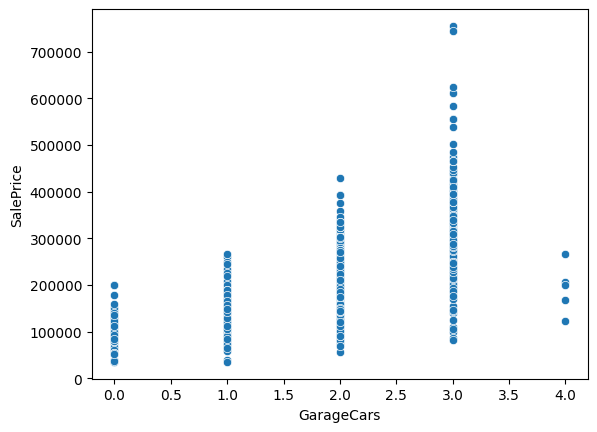

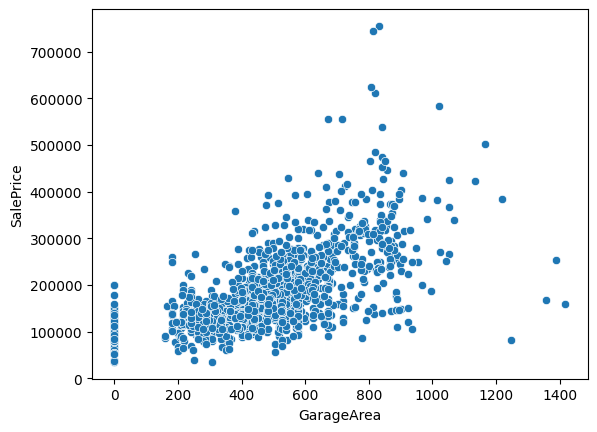

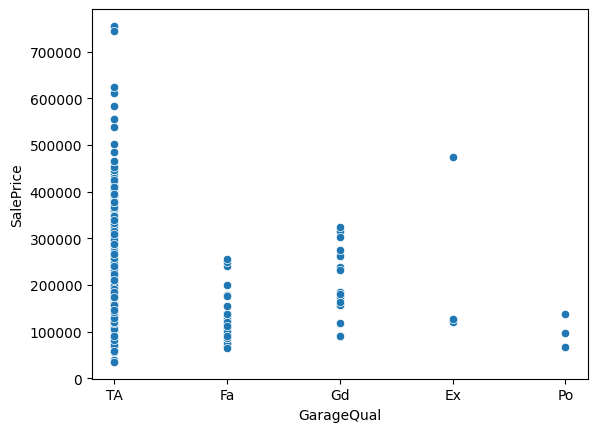

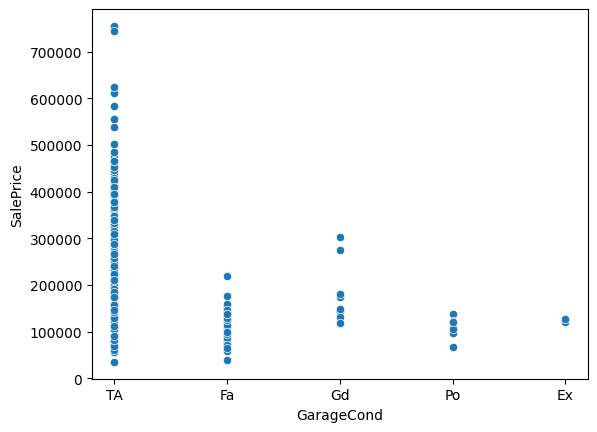

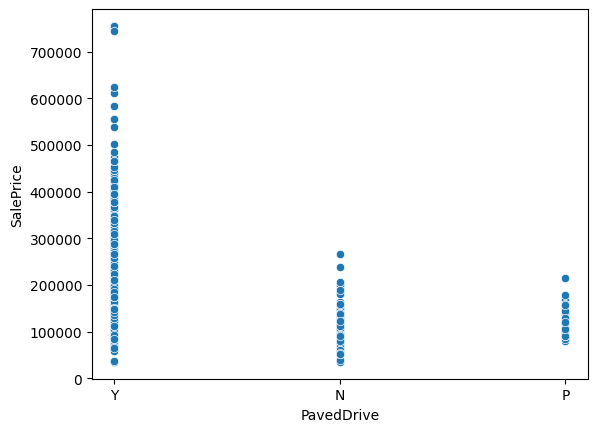

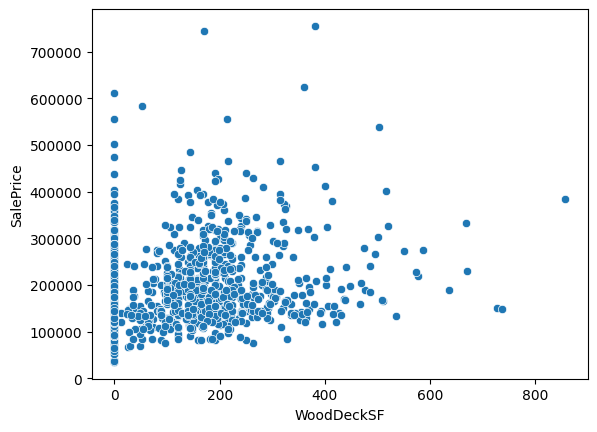

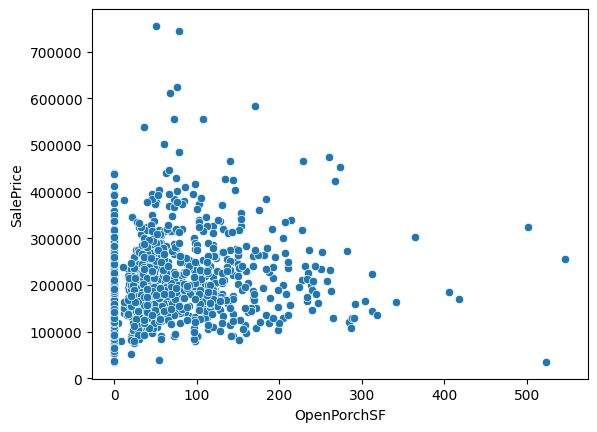

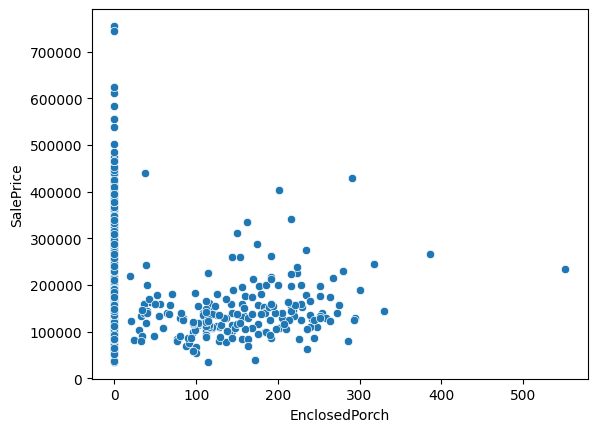

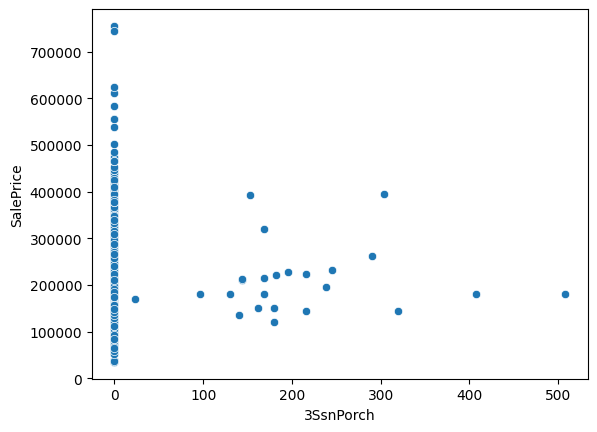

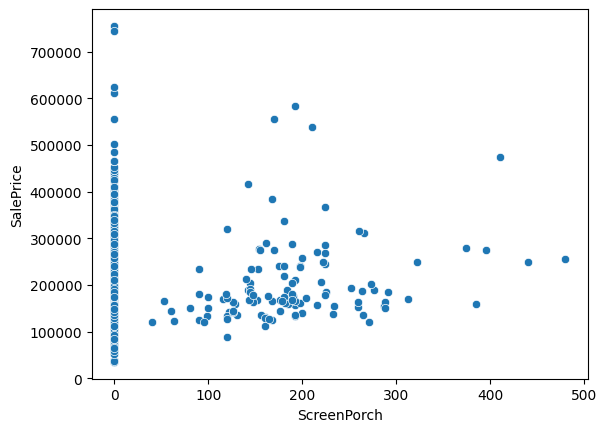

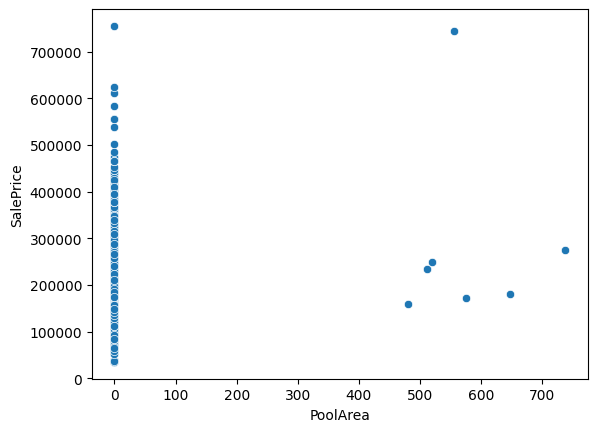

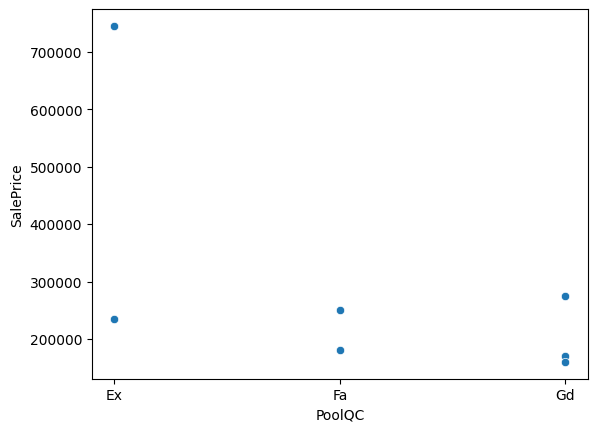

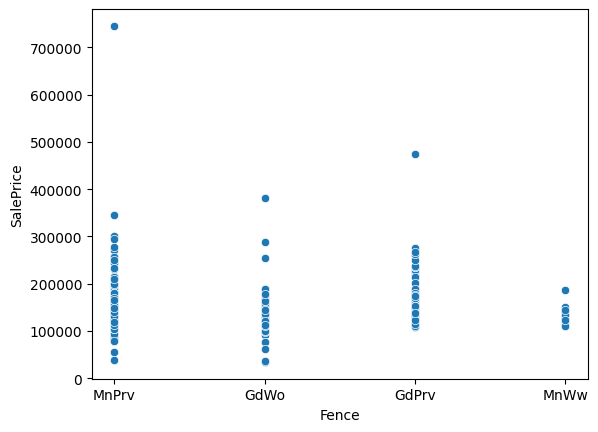

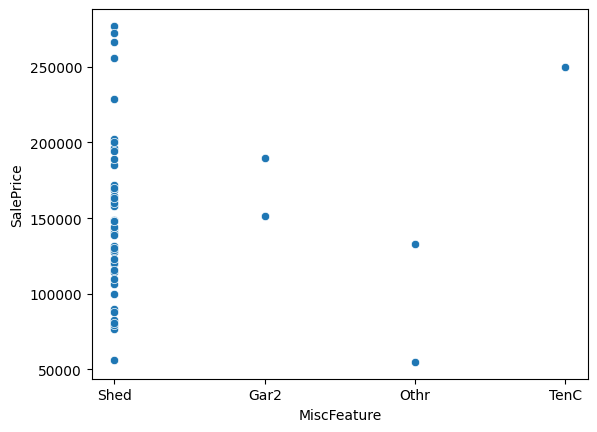

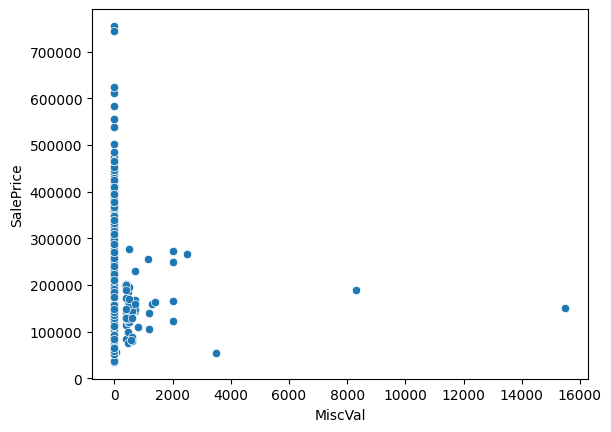

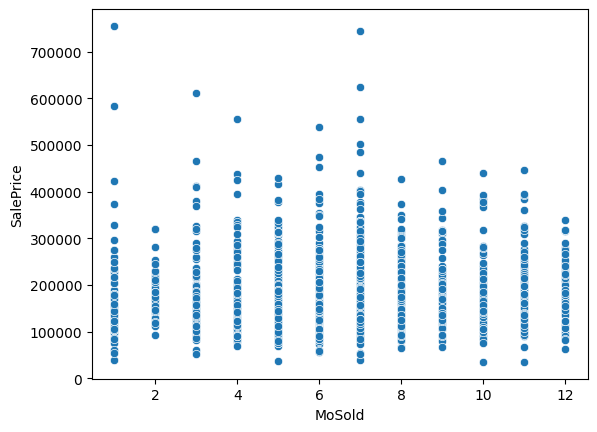

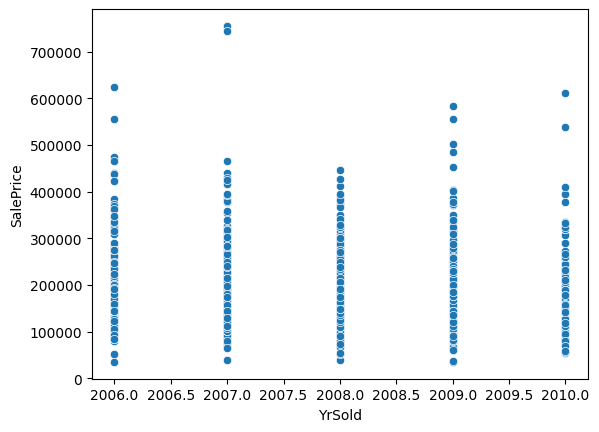

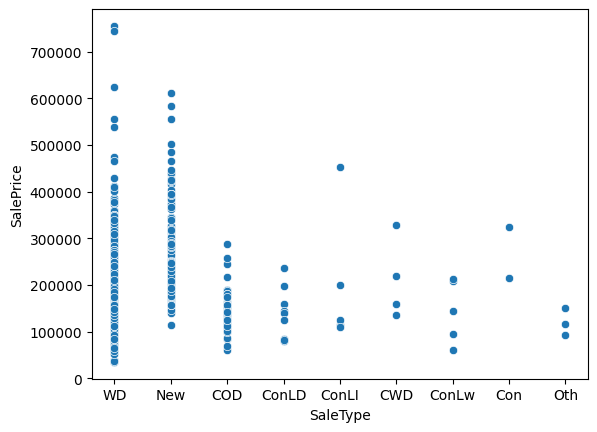

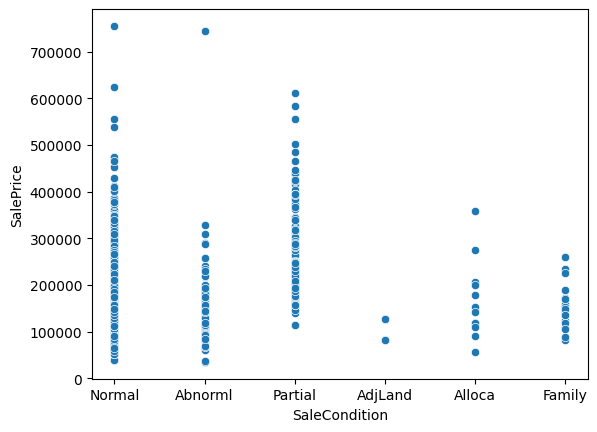

In [139]:
# Extraction des colonnes de variables explicatives
X = train_df.drop("SalePrice", axis=1)

# Affichage des nuages de points entre la variable à expliquer et toutes les variables explicatives avec seaborn
for col in X.columns:
    sns.scatterplot(x=X[col], y=train_df["SalePrice"])
    plt.show()

In [140]:
#Eliminer les outliers en capturant les valeurs extremes
def drop_outliers_lines(df):
    conditions = (
        (df['BsmtFinSF1'] > 5000) |
        (df['BsmtFinSF2'] > 1400) |
        (df['TotalBsmtSF'] > 6000) |
        (df['1stFlrSF'] > 4000) |
        (df['2ndFlrSF'] > 2000) |
        (df['GrLivArea'] > 5000) |
        (df['WoodDeckSF'] > 800) |
        (df['OpenPorchSF'] > 500) |
        (df['EnclosedPorch'] > 450) |
        (df['3SsnPorch'] > 350) |
        (df['MiscVal'] > 8000) |
        (df['LotFrontage'] > 250) |
        (df['LotArea'] > 150000) |
        (df['MasVnrArea'] > 1500) |
        (df['Utilities'] == 'NoSeWa') |
        (df['Exterior1st'].isin(['ImStucc', 'CBlock'])) |
        (df['TotRmsAbvGrd'].isin([2, 14])) |
        (df['Functional'] == 'Sev')
    )


    # Extraire les IDs des lignes à supprimer
    outliers_ids = df.loc[conditions, 'Id']
    print("IDs des lignes à supprimer :", outliers_ids.tolist())

    # Supprimer les lignes du DataFrame
    df = df[~conditions]


In [141]:
drop_outliers_lines(train_df)

# Suppression de la colonne 'Id'
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

# Encodage ciblé des catégorielles importantes
neighborhood_map = train_df.groupby('Neighborhood')['SalePrice'].median().to_dict()



IDs des lignes à supprimer : [54, 56, 198, 206, 250, 298, 314, 323, 336, 347, 496, 534, 584, 636, 667, 935, 945, 1183, 1188, 1231, 1299, 1329, 1371]


Ce sont les ids des valeurs aberrantes que nous avons supprimé

In [142]:
!pip install catboost

#Traitement des valeurs manquantes selon le type et la distribution

In [143]:
# Visualiser les colonnes sui contiennent des valeurs nulles
null_percentage = train_df.isnull().mean() * 100
null_percentage = null_percentage[null_percentage > 0].sort_values(ascending=False)
print(null_percentage)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


In [144]:
# Colonnes numériques avec leur pourcentage de valeurs manquantes
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
null_percentage_numeric = train_df[numeric_cols].isnull().mean() * 100
print("Colonnes numériques avec valeurs manquantes :")
print(null_percentage_numeric[null_percentage_numeric > 0].sort_values(ascending=False))


# Colonnes catégorielles avec leur pourcentage de valeurs manquantes
categorical_cols = train_df.select_dtypes(include=['object']).columns
null_percentage_cat = train_df[categorical_cols].isnull().mean() * 100
print("\nColonnes catégorielles avec valeurs manquantes :")
print(null_percentage_cat[null_percentage_cat > 0].sort_values(ascending=False))

Colonnes numériques avec valeurs manquantes :
LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
dtype: float64

Colonnes catégorielles avec valeurs manquantes :
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
GarageFinish     5.547945
GarageQual       5.547945
GarageType       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtFinType1     2.534247
BsmtCond         2.534247
Electrical       0.068493
dtype: float64


In [145]:
# Afficher les valeurs possibles prises par les colonnes contenent des naan
categorical_features = train_df.select_dtypes(include=['object']).columns
for cat in categorical_features:
    print(f"\n{cat} value counts:")
    print(train_df[cat].value_counts())



MSZoning value counts:
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

Street value counts:
Street
Pave    1454
Grvl       6
Name: count, dtype: int64

Alley value counts:
Alley
Grvl    50
Pave    41
Name: count, dtype: int64

LotShape value counts:
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

LandContour value counts:
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

Utilities value counts:
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

LotConfig value counts:
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64

LandSlope value counts:
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64

Neighborhood value counts:
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74

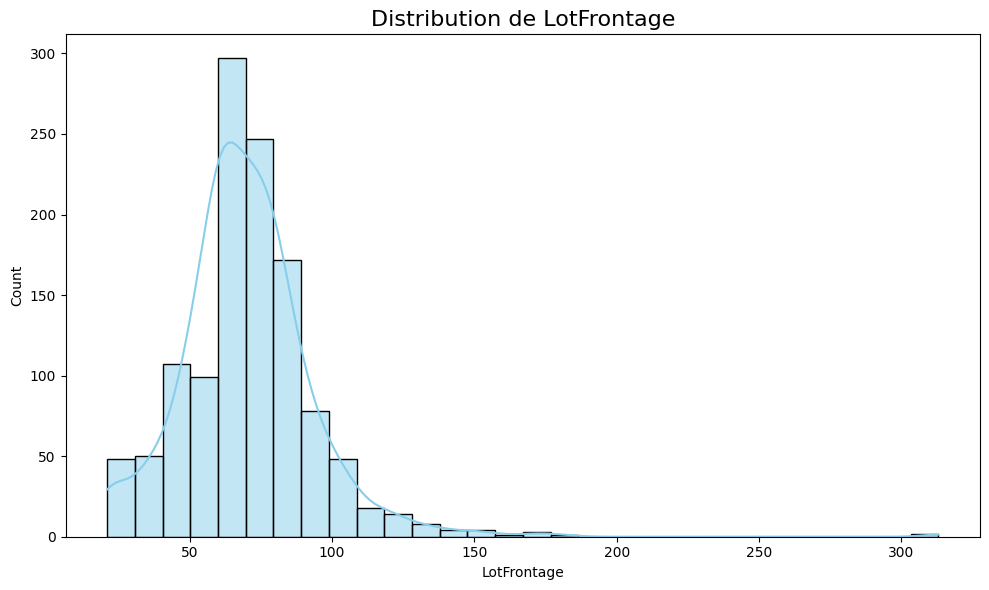

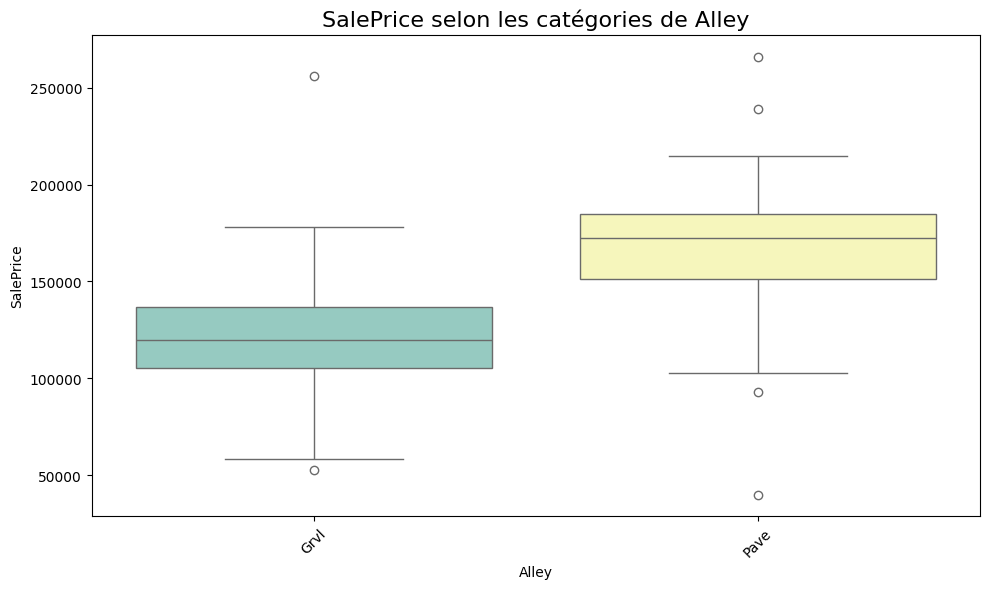

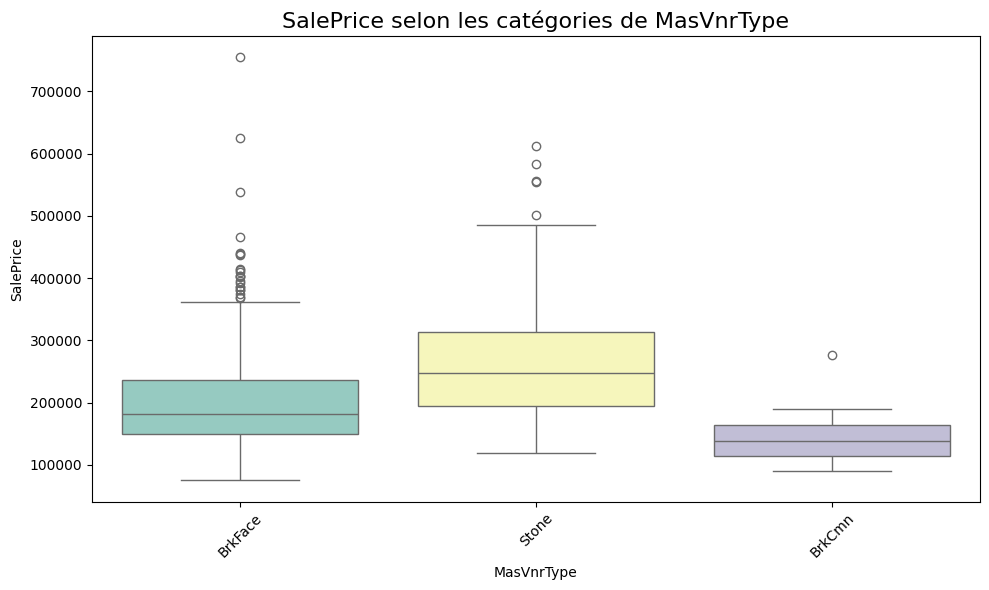

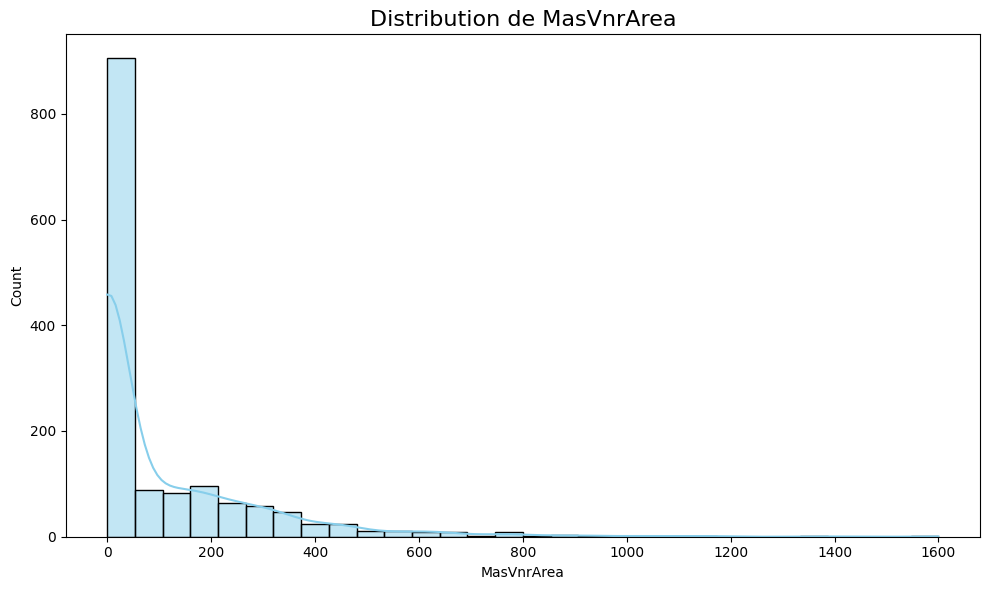

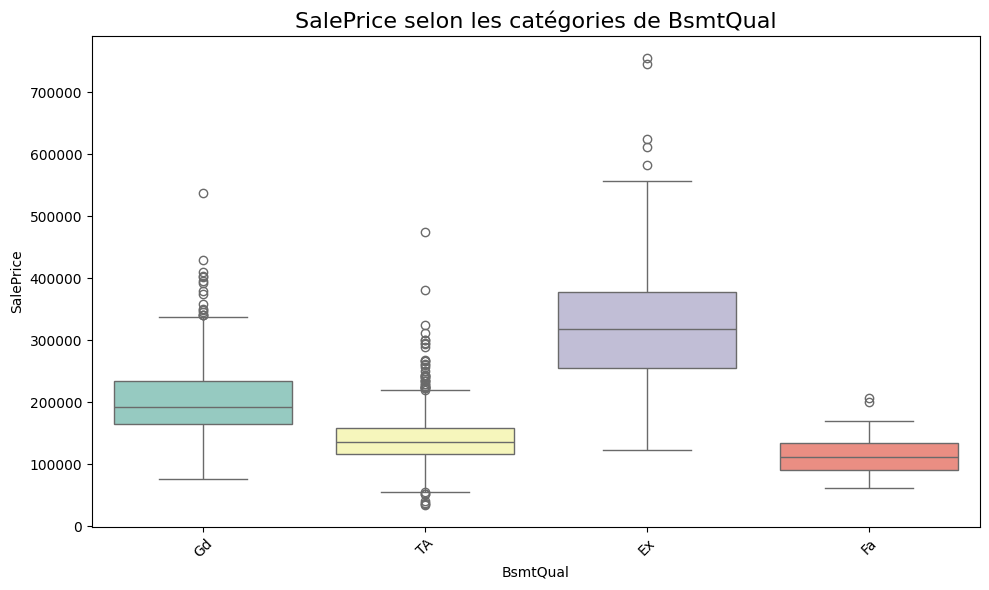

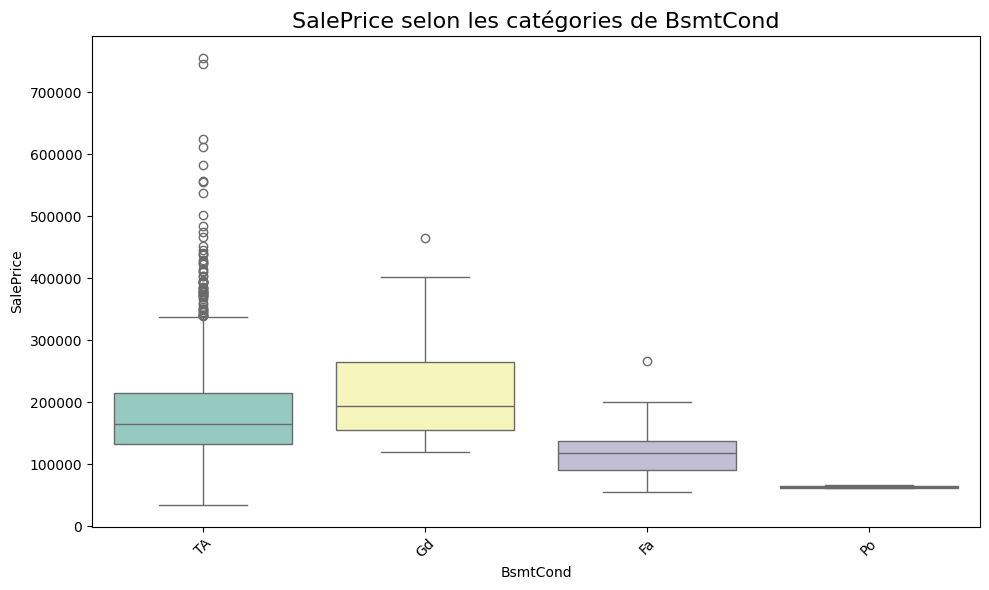

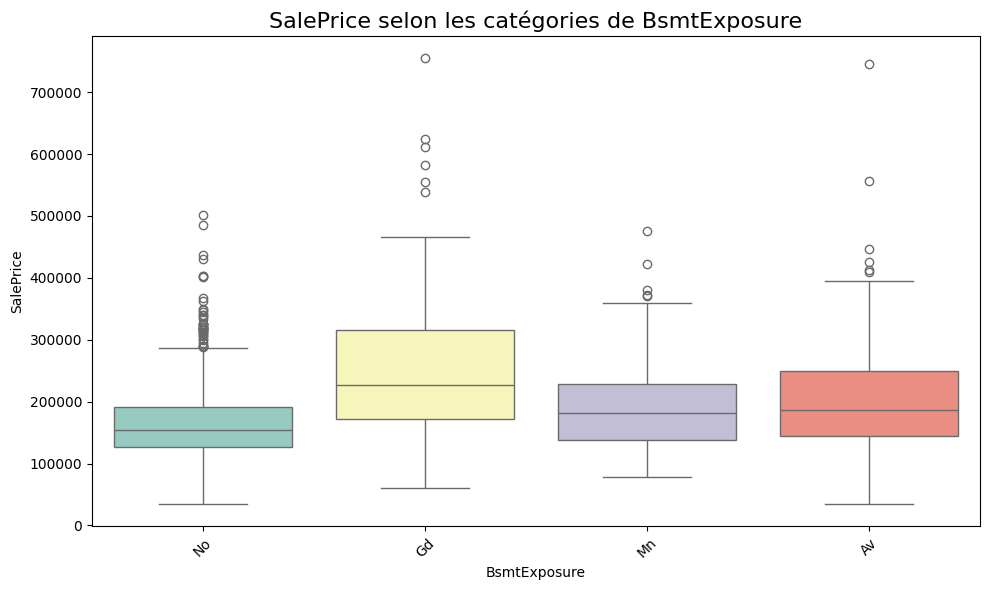

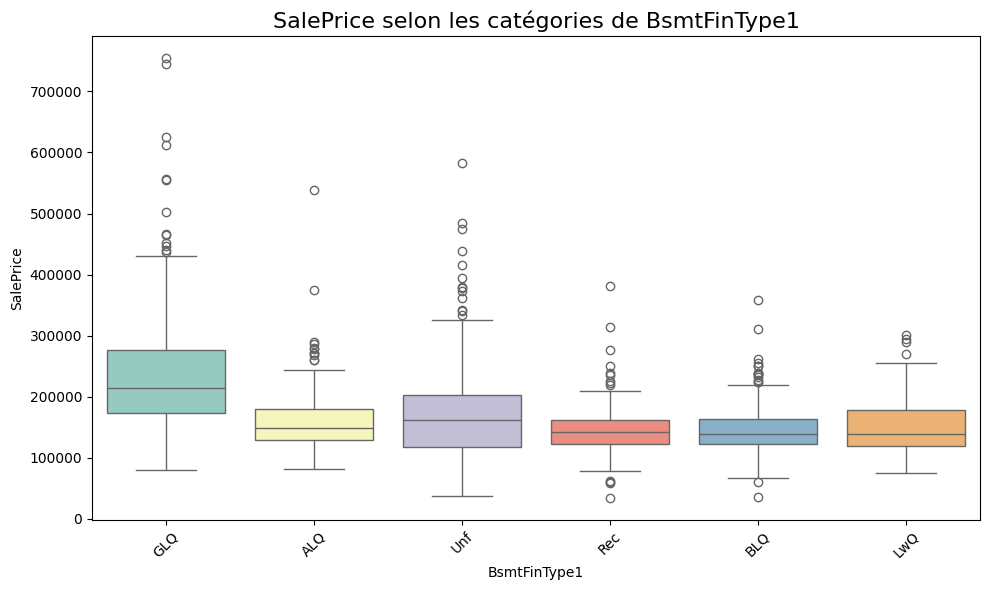

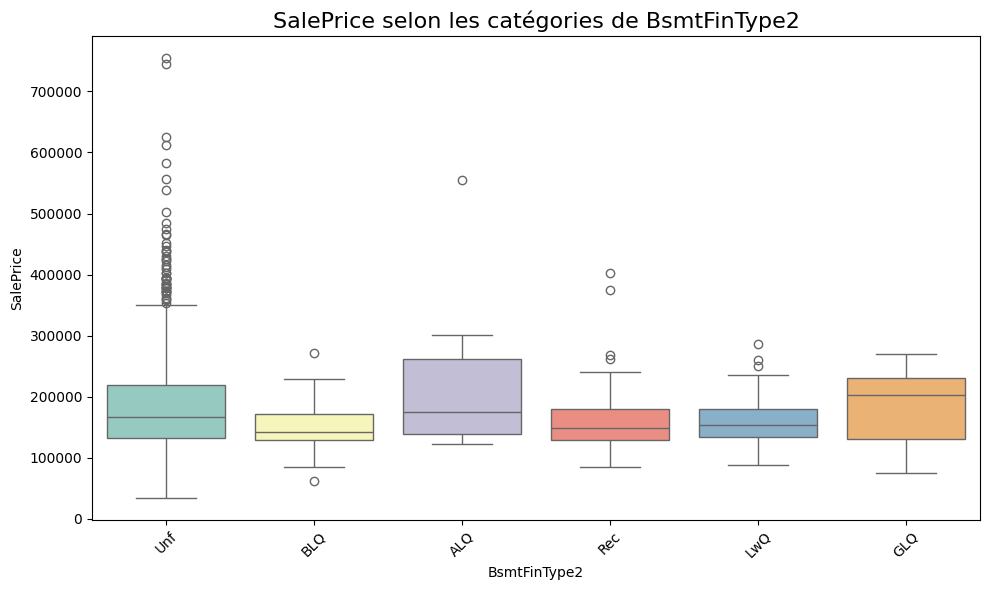

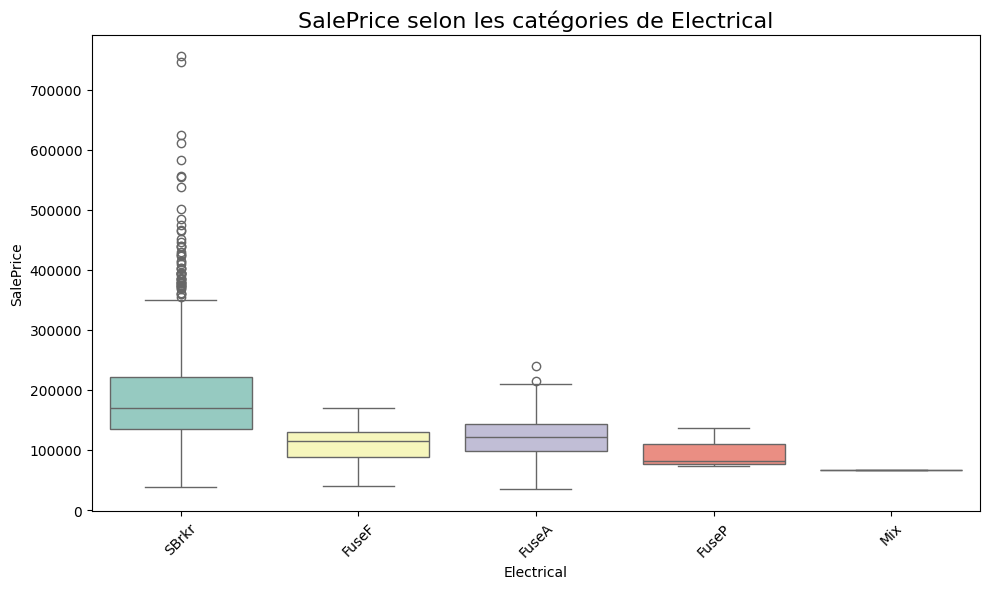

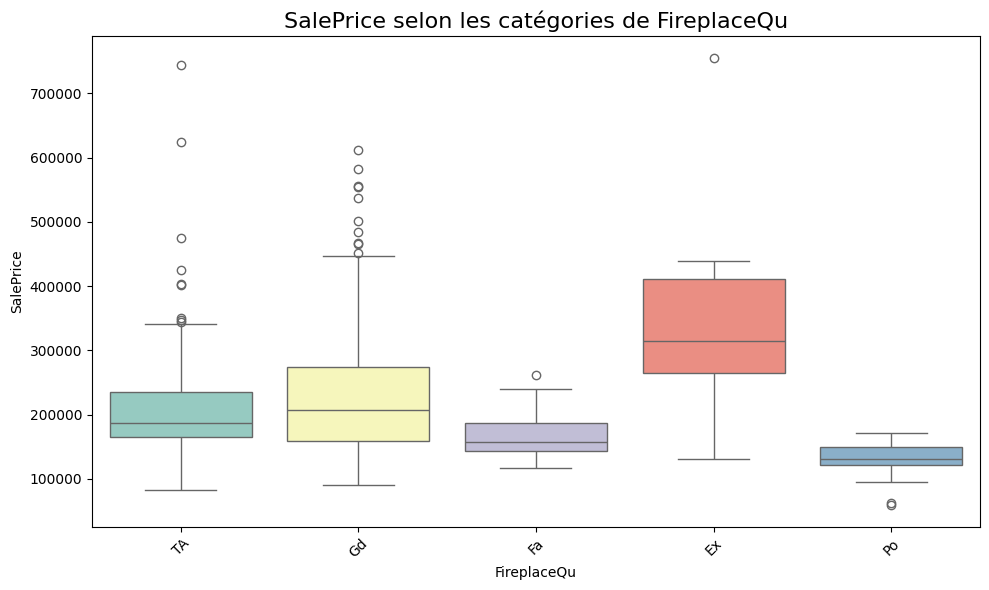

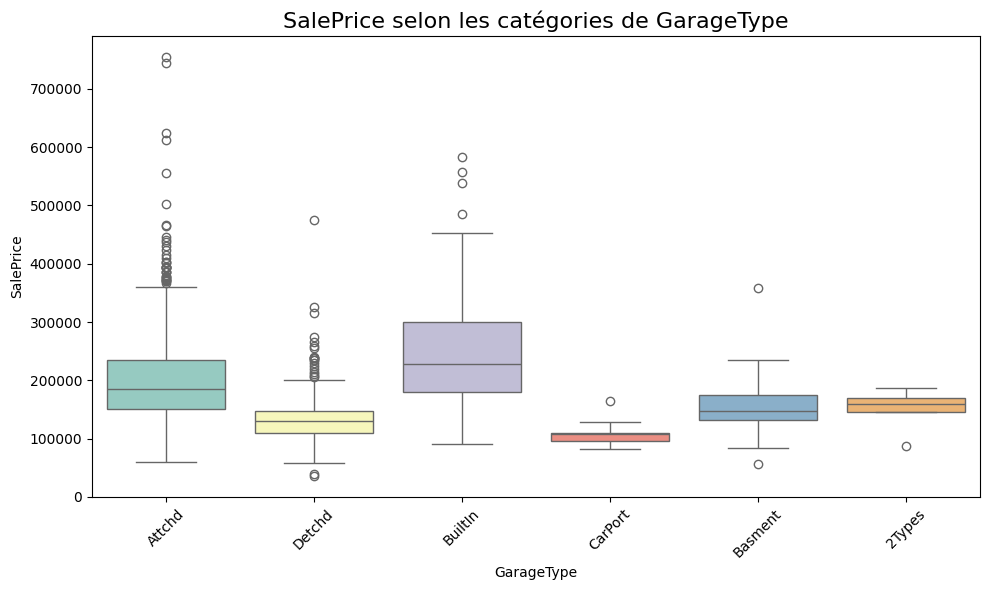

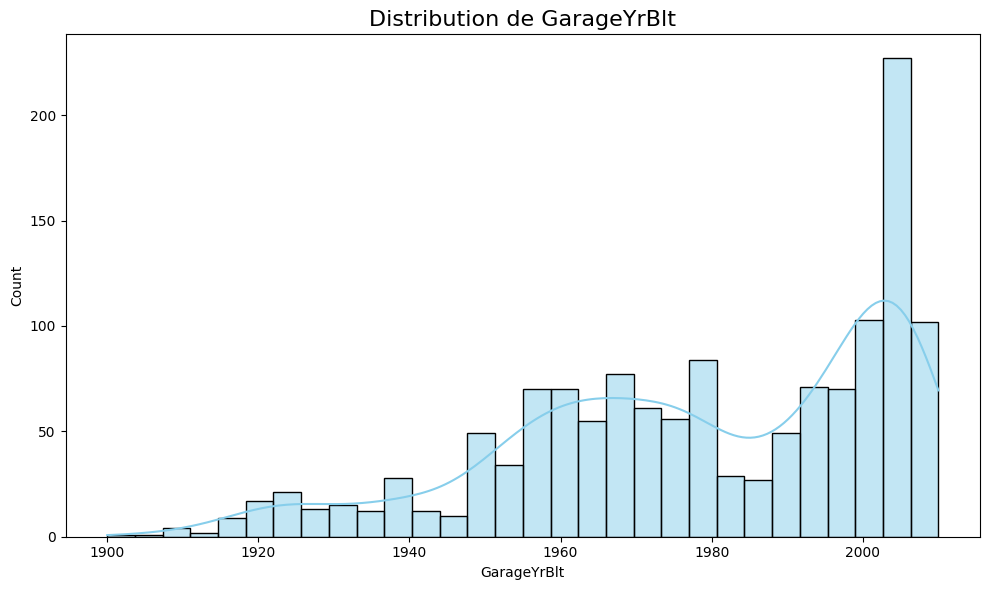

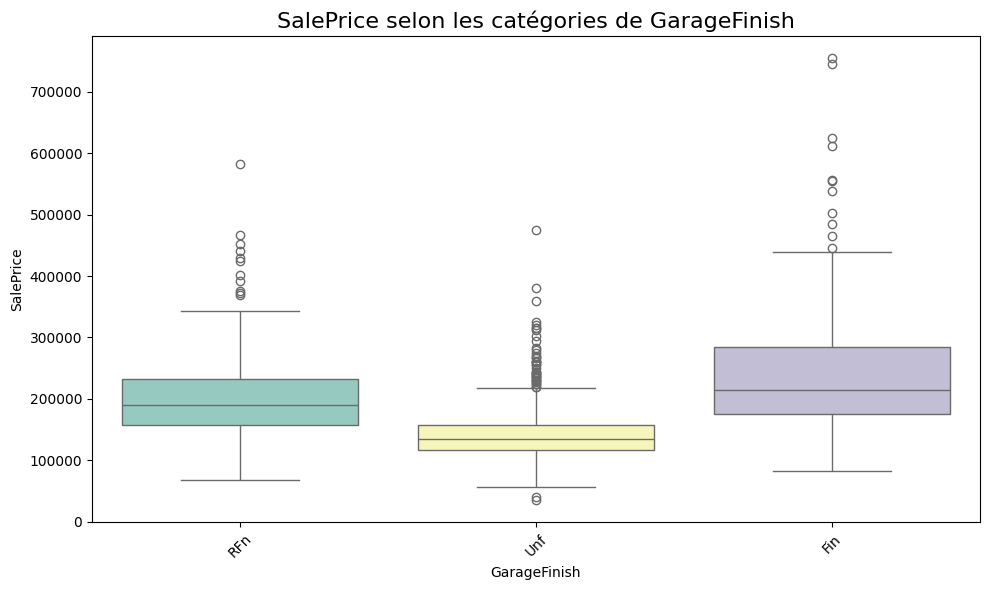

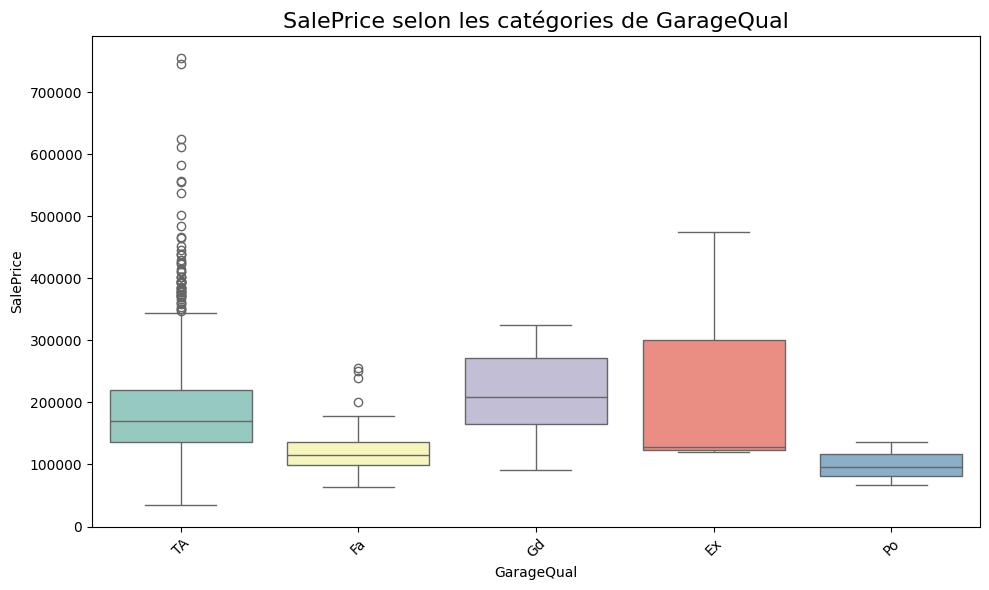

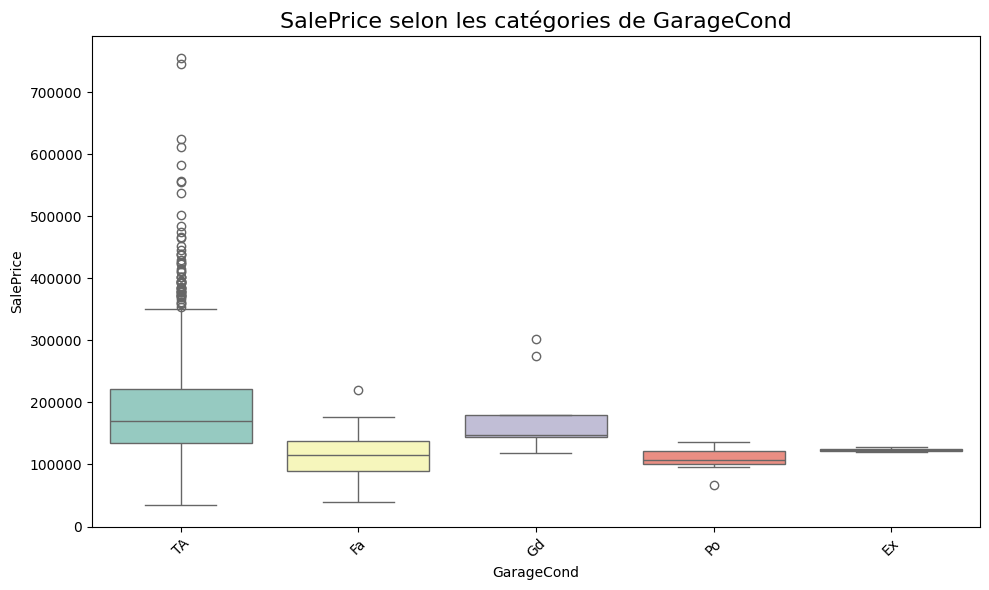

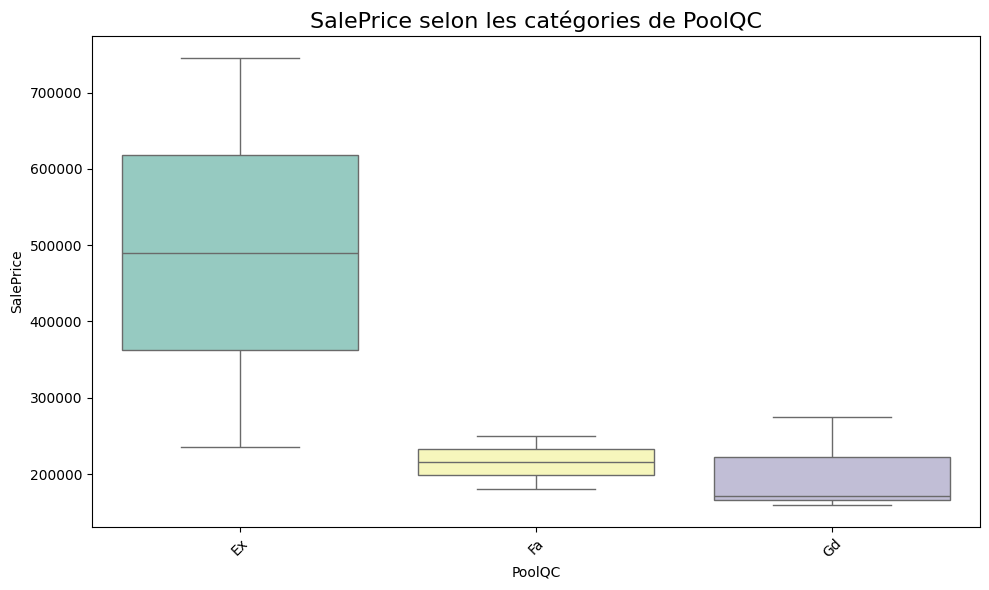

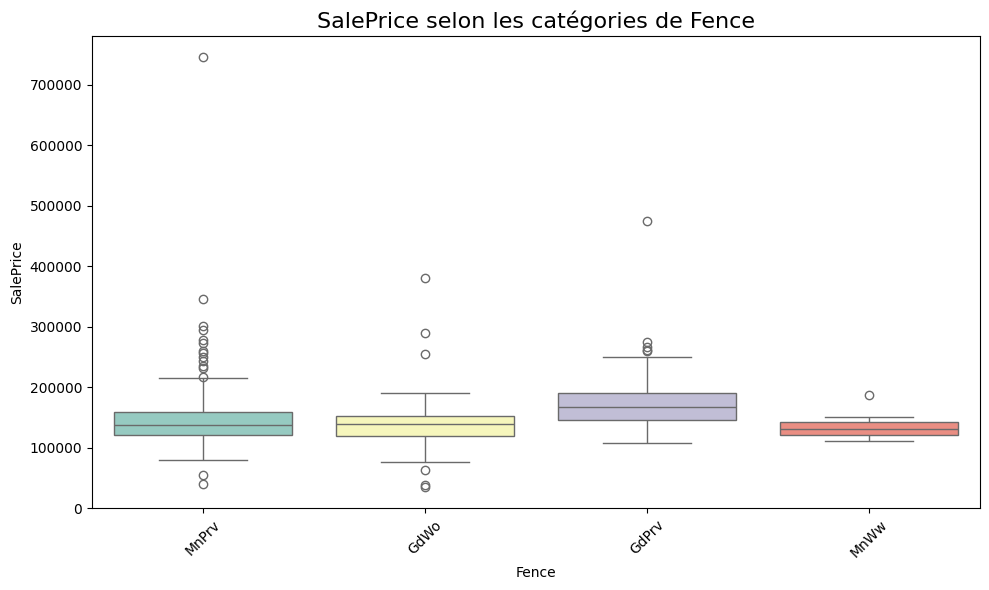

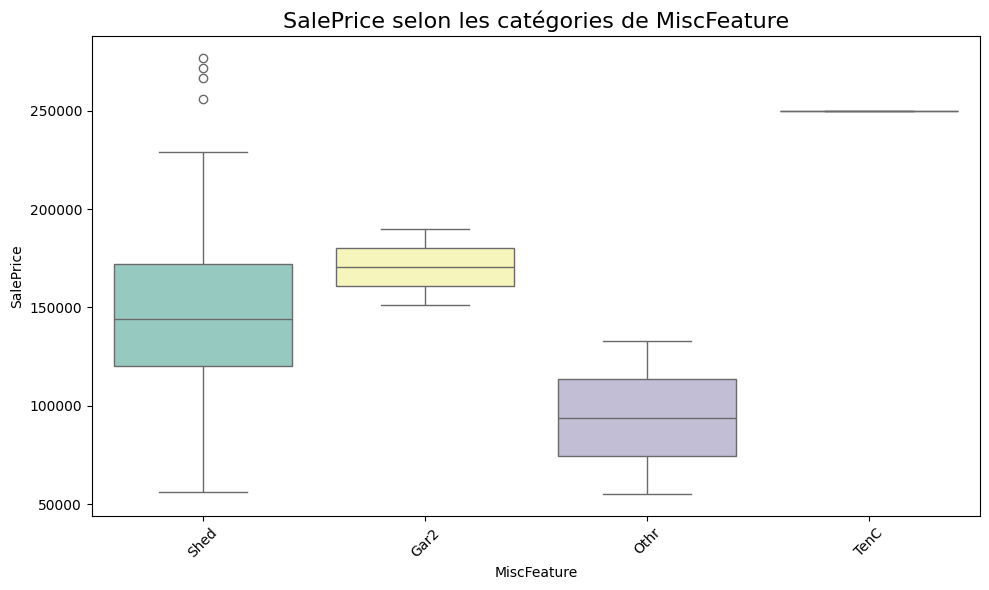

In [146]:
# Visualiser la distribution des valeurs manquantes
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

df = train_df.copy()
cols_with_na = [col for col in df.columns if df[col].isna().any()]
for col in cols_with_na:
    plt.figure(figsize=(10, 6))
    if df[col].dtype == 'object':
        # Boxplot pour variables catégorielles
        sns.boxplot(x=col, y='SalePrice', data=df, palette='Set3')
        plt.title(f'SalePrice selon les catégories de {col}', fontsize=16)
        plt.xticks(rotation=45)
        plt.legend([], [], frameon=False)
    else:
        # Distribution (histogramme) pour variables numériques
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Distribution de {col}', fontsize=16)
    plt.tight_layout()
    plt.show()




In [147]:
# Étape 1 : Fusion des données
train_labels = train_df['SalePrice']
train_df.drop("SalePrice", axis=1, inplace=True)
full_df = pd.concat([train_df, test_df], axis=0)


# Convertion de type si nécessaire
cols_to_convert = ['MSSubClass', 'OverallQual', 'OverallCond']
for col in cols_to_convert:
    if col in full_df.columns:
        full_df[col] = full_df[col].astype('object')


full_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [148]:
# Remplacer les valeurs manquantes dans les colonnes spécifiées
full_df['Alley'] = full_df['Alley'].fillna('No')
full_df['BsmtExposure'] = full_df['BsmtExposure'].fillna('No')
full_df['BsmtFinType1'] = full_df['BsmtFinType1'].fillna('Unf')
full_df['BsmtFinType2'] = full_df['BsmtFinType2'].fillna('Unf')
full_df['GarageFinish'] = full_df['GarageFinish'].fillna('Unt')
# full_df['PoolQC'] = full_df['PoolQC'].fillna('No')

#Encodage des features selon le type

In [149]:
# Ton dictionnaire de mapping ordinal
ordinal_mappings = {
    'LotShape': {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0, 'None': 0},
    'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
    'PoolQC': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'LandContour': {'Lvl': 3, 'Bnk': 2, 'HLS': 1, 'Low': 0, 'None': 0},
    'LandSlope': {'Gtl': 2, 'Mod': 1, 'Sev': 0, 'None': 0},
    'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'None': 0},
    'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'None': 0},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtQual': {'None': 0, 'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'BsmtCond': {'None': 0, 'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'BsmtExposure': {'None': 0, 'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0},
    'BsmtFinType1': {'None': 0, 'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1},
    'BsmtFinType2': {'None': 0, 'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1},
    'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'None': 0},
    'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'None': 0},
    'Functional': {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0, 'None': 0},
    'GarageFinish': {'None': 0, 'Fin': 3, 'RFn': 2, 'Unf': 1},
    'GarageQual': {'None': 0, 'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'GarageCond': {'None': 0, 'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
}



In [150]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   object 
 17  OverallCond    2919 non-null   object 
 18  YearBuilt    

# Feature Engeneering

In [151]:
# Étape 2 : Prétraitement amélioré
def feature_engeneering(df):
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']:
        df[col] = df[col].fillna(0)

    for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
                'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
        df[col] = df[col].fillna('None')

    df.fillna(df.median(numeric_only=True), inplace=True)

    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'])
    df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
    df['GarageAge'] = df['YrSold'] - df['YearBuilt']

    # # Transformation pour améliorer la performance
    df['LotArea_log'] = np.log1p(df['LotArea'])
    df['OverallQual_Sq'] = df['OverallQual']**2  # Interaction entre OverallQual et la qualité

    # df['totalArea']=df['MasVnrArea']+ df['LotArea']+df['GrLivArea']+df['GarageArea']+ df['PoolArea']

    # df['PorchSpace']= df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch']


    df.drop(columns=['Utilities','1stFlrSF','2ndFlrSF','LotArea','GarageArea'])



    # Ordinal Encoding
    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].fillna('None')  # sécurité
            df[col] = df[col].map(mapping)
            df[col] = df[col].fillna(0)
    # Check remaining NaNs after mapping
    missing_after_mapping = df.isnull().sum()
    print("Colonnes avec NaN après mapping :")
    print(missing_after_mapping[missing_after_mapping > 0])
    # Encodage One-Hot des variables catégorielles restantes
    cat_cols = df.select_dtypes(include='object').columns
    df[cat_cols] = df[cat_cols].fillna("Missing")
    df = pd.get_dummies(df, drop_first=True)
    print(df.isnull().sum())
    return df




In [152]:
# Appliquer le feature engeneering
full_df = feature_engeneering(full_df)

Colonnes avec NaN après mapping :
MSZoning       4
Utilities      2
Exterior1st    1
Exterior2nd    1
Electrical     1
SaleType       1
dtype: int64
MSSubClass               0
LotFrontage              0
LotArea                  0
LotShape                 0
LandContour              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 213, dtype: int64


In [153]:
# supprimer les colonnes non significatives suivant les tests effectués
full_df.drop(columns=['LandSlope','PoolQC','Fence'], inplace=True)

# Transformation des distributions assymétriques

In [154]:
# Identifier les variables numériques
numeric_feats = full_df.select_dtypes(include=[np.number]).columns

# Calculer la skewness
skewed_feats = full_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# Ne conserver que les variables très skewed
skewed_feats = skewed_feats[skewed_feats > 0.75]
print(f"{len(skewed_feats)} skewed features à transformer")

# Appliquer la transformation Box-Cox avec λ = 0.15
for feat in skewed_feats.index:
    full_df[feat] = boxcox1p(full_df[feat], 0.15)


# cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence','MasVnrType']
# train_df.drop(cols_to_drop, axis=1, inplace=True)

30 skewed features à transformer


In [155]:
corr_matrix = full_df.corr().abs()
high_corr = np.where(corr_matrix > 0.9)
high_corr = [(corr_matrix.columns[x], corr_matrix.columns[y])
             for x,y in zip(*high_corr) if x != y and x < y]

for col1, col2 in high_corr:
    if col1 in full_df.columns and col2 in full_df.columns:
        full_df.drop(np.random.choice([col1, col2]), axis=1, inplace=True)

In [156]:
# Tester s'il y a des des valeurs nulles
def check_and_clean_nan(full_df, train_labels):
    # 1. Vérification complète des NaN
    nan_report = full_df.isnull().sum()
    nan_cols = nan_report[nan_report > 0]

    if not nan_cols.empty:
        print("🔥 Colonnes avec NaN :")
        print(nan_cols)

        # 2. Nettoyage ciblé
        for col in nan_cols.index:
            if full_df[col].dtype.kind in 'iuf':  # Numérique
                full_df[col].fillna(full_df[col].median(), inplace=True)
            else:  # Catégoriel
                full_df[col].fillna('Missing', inplace=True)

        print("✅ NaN traités")
    else:
        print("✅ Aucun NaN détecté")

    # 3. Vérification finale
    assert not full_df.isnull().any().any(), "Il reste des NaN !"
    return full_df, train_labels

# Utilisation
full_df, train_labels = check_and_clean_nan(full_df, train_labels)

✅ Aucun NaN détecté


#Entrainement des modèles

In [157]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [158]:
def normaliser(full_df):
    # Étape 1 : Normalisation des données avec RobustScaler
    scaler = RobustScaler()
    # Appliquer le scaling aux colonnes numériques
    numeric_cols = full_df.select_dtypes(include=np.number).columns
    full_df[numeric_cols] = scaler.fit_transform(full_df[numeric_cols])


normaliser(full_df)

# Étape 2 : Répartition des données
X = full_df.iloc[:len(train_df), :]
X_test = full_df.iloc[len(train_df):, :]
y = np.log1p(train_labels)


Meilleurs paramètres CatBoost : {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 1000, 'depth': 5, 'bagging_temperature': 0}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3135
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 123
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2960
[LightGBM] [Info] Number of data points i

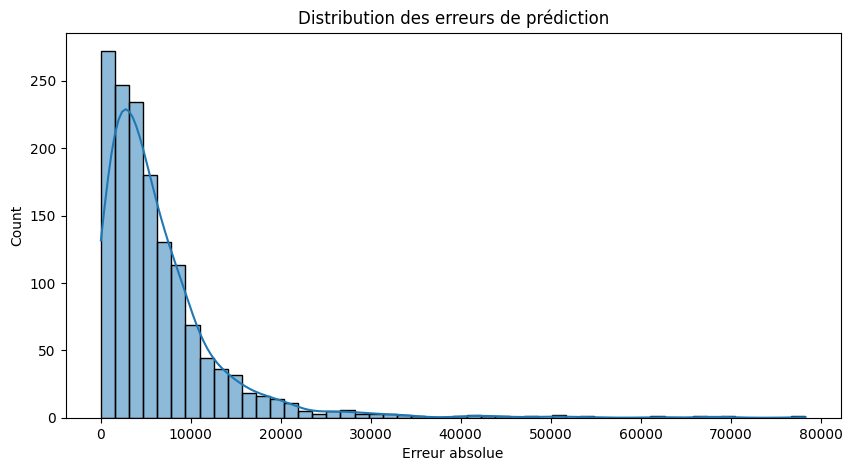

MSE : 92196545.96
RMSE : 9601.90
R² : 0.9854


In [159]:
# Étape 3 : Définir les modèles individuels
ridge = Ridge()
# lasso = Lasso()
xgb_model = xgb.XGBRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)
cat_model = CatBoostRegressor(random_seed=42, verbose=0)
rf_model = RandomForestRegressor(random_state=42)
# linear_reg = LinearRegression()

# Étape 4 : Modèle d'assemblage (stacking)
estimators = [
    ('ridge', ridge),
    # ('lasso', lasso),
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('cat', cat_model),
    ('rf', rf_model),


    # ('linear', linear_reg),
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# Étape 5 : Optimisation des hyperparamètres avec RandomizedSearchCV
param_dist = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
}

# RandomizedSearchCV pour CatBoost (exemple, à répéter pour d'autres modèles si nécessaire)
catboost_model = CatBoostRegressor(random_seed=42, verbose=0)
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
random_search.fit(X, y)
print(f"Meilleurs paramètres CatBoost : {random_search.best_params_}")

# Étape 6 : Validation croisée et évaluation du modèle d'assemblage
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -cross_val_score(stacking_model, X, y, scoring="neg_root_mean_squared_error", cv=kf)
print(f"RMSE moyen en validation croisée: {scores.mean():.4f}")

# Étape 7 : Entraînement final et prédictions
stacking_model.fit(X, y)
preds = np.expm1(stacking_model.predict(X_test))

# Étape 8 : Création du fichier de soumission
submission = pd.DataFrame({"Id": test_ID, "SalePrice": preds})
submission.to_csv("submission.csv", index=False)

# Étape 9 : Analyse des erreurs
train_preds = np.expm1(stacking_model.predict(X))
errors = np.abs(train_preds - np.expm1(y))

# Affichage de l'histogramme des erreurs
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=50, kde=True)
plt.title("Distribution des erreurs de prédiction")
plt.xlabel("Erreur absolue")
plt.show()

# Calcul du MSE, RMSE, et R²
mse = mean_squared_error(np.expm1(y), train_preds)
rmse = np.sqrt(mse)
r2 = r2_score(np.expm1(y), train_preds)

print(f"MSE : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.4f}")


In [160]:
from sklearn.metrics import mean_squared_error, r2_score

# Calcul des métriques
mse = mean_squared_error(np.expm1(y), train_preds)
rmse = np.sqrt(mse)
r2 = r2_score(np.expm1(y), train_preds)

# Affichage des métriques
print(f"MSE : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.4f}")


MSE : 92196545.96
RMSE : 9601.90
R² : 0.9854


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

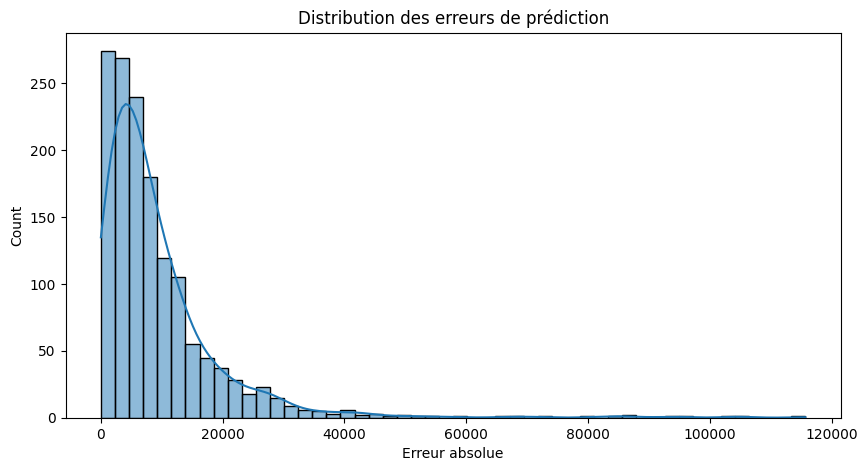

MSE : 208227698.74
RMSE : 14430.10
R² : 0.9670


In [162]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Normalisation
def normaliser(full_df):
    scaler = RobustScaler()
    numeric_cols = full_df.select_dtypes(include=np.number).columns
    full_df[numeric_cols] = scaler.fit_transform(full_df[numeric_cols])

normaliser(full_df)

# Répartition des données
X = full_df.iloc[:len(train_df), :]
X_test = full_df.iloc[len(train_df):, :]
y = np.log1p(train_labels)

# Définir les grilles de recherche
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
xgb_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
}
lgb_params = {
    'n_estimators': [100, 300, 500],
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
}
cat_params = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
}
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# RandomizedSearchCV pour chaque modèle
def optimize_model(model, params, name):
    search = RandomizedSearchCV(model, params, n_iter=10, cv=3,
                                scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X, y)
    print(f"Meilleurs paramètres pour {name} : {search.best_params_}")
    return search.best_estimator_

ridge_best = optimize_model(Ridge(), ridge_params, "Ridge")
xgb_best = optimize_model(xgb.XGBRegressor(random_state=42), xgb_params, "XGBoost")
lgb_best = optimize_model(lgb.LGBMRegressor(random_state=42), lgb_params, "LightGBM")
cat_best = optimize_model(CatBoostRegressor(random_seed=42, verbose=0), cat_params, "CatBoost")
rf_best = optimize_model(RandomForestRegressor(random_state=42), rf_params, "RandomForest")

# Modèle stacking avec les meilleurs estimateurs
estimators = [
    ('ridge', ridge_best),
    ('xgb', xgb_best),
    ('lgb', lgb_best),
    ('cat', cat_best),
    ('rf', rf_best),
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# Validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -cross_val_score(stacking_model, X, y, scoring="neg_root_mean_squared_error", cv=kf)
print(f"RMSE moyen en validation croisée: {scores.mean():.4f}")

# Entraînement final et prédictions
stacking_model.fit(X, y)
preds = np.expm1(stacking_model.predict(X_test))

# Création du fichier de soumission
submission = pd.DataFrame({"Id": test_ID, "SalePrice": preds})
submission.to_csv("submission_grid_search.csv", index=False)

# Analyse des erreurs
train_preds = np.expm1(stacking_model.predict(X))
errors = np.abs(train_preds - np.expm1(y))

plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=50, kde=True)
plt.title("Distribution des erreurs de prédiction")
plt.xlabel("Erreur absolue")
plt.show()

mse = mean_squared_error(np.expm1(y), train_preds)
rmse = np.sqrt(mse)
r2 = r2_score(np.expm1(y), train_preds)

print(f"MSE : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.4f}")
